# CMIP6 VP+Evap Calibration Pipeline

## Overview

This notebook performs monthly mean/variance calibration of VP and Evap across multiple models, scenarios, and coordinates, then generates calibrated APSIM .met files matching the template format.

## Calculation Process

### Step 1: Parametrization (Historical Baseline Calibration)

**Data Requirements:**
- **SILO comparison file (1986-2014):** Extracted using SILO API Module_Workflow (silo_met_file_creation.py)
  - Period 1986-2014: Used for VP and EVAP calibration (CMIP6 obs data only covers 1985-2014)
  - Period 1995-2024: Used for trends analysis (report storyline of last 30 years) - *not used in this calibration step*
- **CMIP6 obs data (1985-2014):** Historical baseline period for calibration parametrization

**For each model–coordinate combination:**
- Daily time series are aligned for the calibration period (1986-2014)
- **VP calibration:**
  - SILO observed VP (hPa) - target series
  - CMIP6-derived VP proxy (daily-mean VP, hPa) - source series
- **EVAP calibration:**
  - SILO observed pan evaporation (mm/day) - target series
  - CMIP6-derived ET₀ (FAO-56 ET₀) proxy (mm/day) - source series

**Monthly Bias Correction Framework:**
Bias correction is applied by calendar month to respect seasonal structure. For each month m (1-12), separately for VP and EVAP:

1. **Compute statistics:**
   - Mean and standard deviation for SILO (target): μₛ(m), σₛ(m)
   - Mean and standard deviation for CMIP6 obs (source): μ꜀(m), σ꜀(m)

2. **Apply mean–variance bias correction (standardisation + rescaling):**
   For each CMIP6 value x in month m, the calibrated value x′ is computed as:
   ```
   x′ = μₛ(m) + (x − μ꜀(m)) × (σₛ(m) / σ꜀(m))
   ```
   Where:
   - μₛ(m) = SILO mean for month m (target)
   - μ꜀(m) = CMIP6 obs mean for month m (source)
   - σₛ(m) = SILO standard deviation for month m (target)
   - σ꜀(m) = CMIP6 obs standard deviation for month m (source)
   
   **Special cases:**
   - If σ꜀(m) ≈ 0, apply mean shift only: `x′ = x + (μₛ(m) − μ꜀(m))`
   - Enforce physical bounds: VP ≥ 0, EVAP ≥ 0

3. **Calibration period:** 1986-2014 (historical overlap period where both SILO and CMIP6 obs data are available)

**Note:** This calibration period (1986-2014) is used only for calibration parametrization, not for trend reporting.

### Step 2: Calibration of Future Scenarios

**Apply calibration to all CMIP6 time periods:** The fixed monthly bias-correction relationship—derived once from 1986–2014—is applied to every CMIP6 value outside the calibration period, without recomputing or updating any statistics.

**Calibration targets:**
- `ACCESS_CM2_obs` (QC / verification) - applies calibration to verify the correction works on the baseline period
- `ACCESS_CM2_SSP245` - future scenario
- `ACCESS_CM2_SSP585` - future scenario

**Calibration parameters (calculated once in Step 1):**
From the 1986-2014 baseline period, for each month m (1-12), separately for VP and EVAP:
- μ꜀(m) — CMIP6 baseline mean
- σ꜀(m) — CMIP6 baseline std
- μₛ(m) — SILO baseline mean
- σₛ(m) — SILO baseline std

**Application process:**
For every CMIP6 (modelled) day, including future periods:

1. **Identify the calendar month m** of the current day
2. **Take the raw VP or EVAP CMIP6 value x**
3. **Apply the already-derived transformation:**
   ```
   x′ = μₛ(m) + (x − μ꜀(m)) × (σₛ(m) / σ꜀(m))
   ```
   Where:
   - x = raw CMIP6 value for the day
   - μₛ(m) = SILO baseline mean for month m (target anchor)
   - μ꜀(m) = CMIP6 baseline mean for month m (source reference)
   - σₛ(m) = SILO baseline std for month m (target scale)
   - σ꜀(m) = CMIP6 baseline std for month m (source scale)
   
   **Special cases:**
   - If σ꜀(m) ≈ 0, apply mean shift only: `x′ = x + (μₛ(m) − μ꜀(m))`
   - Enforce physical bounds: VP ≥ 0, EVAP ≥ 0

**Key properties:**
- The baseline anchor is SILO (μₛ(m))
- The anomaly is preserved and only rescaled
- The trend embedded in (x − μ꜀(m)) survives intact

**Important:** The bias-correction parameters derived over the historical overlap period (1986–2014) are held fixed and applied to all CMIP6 time periods, including future SSP projections. Each daily CMIP6 value is transformed using the month-specific correction relationship, ensuring consistency with SILO climatology while preserving the magnitude and temporal structure of projected anomalies.

## Process Flow

1. Uses configured model/scenario/coordinates from configuration section (specified per run)
2. Loads SILO baseline (1986-2014) and CMIP6 obs .met files + VP/Evap proxy CSVs
3. Applies monthly mean/variance scaling calibration (Step 1: parametrization on 1986-2014 baseline)
4. Applies calibration to future scenarios (Step 2: uses parametrization from Step 1)
5. Generates calibrated .met files matching template format
6. Produces diagnostics and calibration reports


## Section 1: Imports and Configuration


In [40]:
import pandas as pd
import numpy as np
import glob
import os
import re
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")


Libraries imported successfully


## Section 2: Configuration

**IMPORTANT:** Adjust the values below for each run.


In [41]:
# CONFIGURATION - CHANGE VALUES BELOW AS NEEDED
# ============================================================================
# All other settings will automatically adjust based on these values

# Input directories
INPUT_MET_DIR = r"C:\Users\ibian\Desktop\ClimAdapt\Anameka\Anameka Climate Files_2901\-31.45_117.55_Climate Files"  # Directory containing raw .met files (SILO + CMIP6 obs + CMIP6 futures) and VP/Evap proxy CSVs

# Output directory (adjust per run)
OUTPUT_DIR = r"C:\Users\ibian\Desktop\ClimAdapt\Anameka\Anameka Climate Files_2901\-31.45_117.55_Climate Files"  # Directory where calibrated .met files and reports will be saved

# Template .met file path
TEMPLATE_MET_FILE = r"C:\Users\ibian\Desktop\ClimAdapt\Anameka\Anameka_South_16_226042\APSIM met file structure.met"

# Baseline period - scenario-dependent
# For obs scenario: use historical overlap period (1986-2014)
# For SSP scenarios: use future period (2035-2064)
# Note: Calibration parametrization always uses historical period (1986-2014) for SILO comparison
def get_baseline_period(scenario):
   
    if scenario.lower() == "obs":
        return "1986-01-01", "2014-12-31"
    else:
        # SSP scenarios use future period
        return "2035-01-01", "2064-12-31"

# Historical calibration period (used for parametrization - always 1986-2014)
CALIBRATION_START = "1986-01-01"
CALIBRATION_END = "2014-12-31"

MODEL = "ACCESS_CM2"
SCENARIOS = ["SSP585"]  # Process obs, SSP245, and SSP585
# Note: The notebook will process all scenarios (obs, SSP245, SSP585) automatically

COORDINATES = [
    (-31.45, 117.55),  # Adjust per run - can include multiple coordinates
]

# ============================================================================
# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("="*70)
print("CONFIGURATION")
print("="*70)
print(f"  Model: {MODEL}")
print(f"  Scenarios: {SCENARIOS}")
print(f"  Coordinates: {COORDINATES}")
print(f"  Input MET Directory: {INPUT_MET_DIR}")
print(f"  Output Directory: {OUTPUT_DIR}")
print(f"  Template MET File: {TEMPLATE_MET_FILE}")
print(f"  Baseline Period: {BASELINE_START} to {BASELINE_END}")
print("="*70)
print("\nAll paths and filenames will automatically use the above settings.\n")


CONFIGURATION
  Model: ACCESS_CM2
  Scenarios: ['SSP585']
  Coordinates: [(-31.45, 117.55)]
  Input MET Directory: C:\Users\ibian\Desktop\ClimAdapt\Anameka\Anameka Climate Files_2901\-31.45_117.55_Climate Files
  Output Directory: C:\Users\ibian\Desktop\ClimAdapt\Anameka\Anameka Climate Files_2901\-31.45_117.55_Climate Files
  Template MET File: C:\Users\ibian\Desktop\ClimAdapt\Anameka\Anameka_South_16_226042\APSIM met file structure.met
  Baseline Period: 1986-01-01 to 2014-12-31

All paths and filenames will automatically use the above settings.



## Section 3: Target Generation


In [42]:
def generate_targets(model, scenarios, coordinates):
    """
    Generate targets for the configured model/scenario across coordinates.
    
    Parameters:
    -----------
    model : str
        Model name (must use underscores, e.g., "ACCESS_CM2")
    scenarios : list
        List of scenario names (e.g., ["ssp245", "ssp585"])
        Scenario name
    coordinates : list
        List of (latitude, longitude) tuples
    
    Returns:
    --------
    list
        List of target dictionaries: [{"model": str, "scenario": str, "lat": float, "lon": float}, ...]
    """
    # Simplified: Use list comprehension instead of nested loops
    return [
        {"model": model, "scenario": scenario, "lat": lat, "lon": lon}
        for lat, lon in coordinates
        for scenario in scenarios
    ]


print(f"Generated {len(generate_targets(MODEL, SCENARIOS, COORDINATES))} target(s) for processing")


Generated 1 target(s) for processing


## Section 4: File Loading Functions


In [43]:
def load_met_file(filepath):
    """
    Load and parse .met file.
    
    Parameters:
    -----------
    filepath : str
        Path to .met file
    
    Returns:
    --------
    tuple: (header_dict, data_df)
        header_dict: Dictionary with metadata (lat, lon, tav, amp, etc.)
        data_df: DataFrame with columns: date, year, day, radn, maxt, mint, rain, evap, vp, code
    """
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"MET file not found: {filepath}")
    
    header_dict = {}
    data_lines = []
    in_header = True
    
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            
            if in_header:
                # Parse header metadata
                if line.startswith('latitude'):
                    match = re.search(r'latitude\s*=\s*([-\d.]+)', line)
                    if match:
                        header_dict['latitude'] = float(match.group(1))
                elif line.startswith('longitude'):
                    match = re.search(r'longitude\s*=\s*([-\d.]+)', line)
                    if match:
                        header_dict['longitude'] = float(match.group(1))
                elif line.startswith('tav'):
                    match = re.search(r'tav\s*=\s*([-\d.]+)', line)
                    if match:
                        header_dict['tav'] = float(match.group(1))
                elif line.startswith('amp'):
                    match = re.search(r'amp\s*=\s*([-\d.]+)', line)
                    if match:
                        header_dict['amp'] = float(match.group(1))
                
                # Check if we've reached the data section
                if line.startswith('year') and 'day' in line:
                    in_header = False
                    continue  # Skip the column header line
            else:
                # Data section
                if line and not line.startswith('!'):
                    # Skip unit line like " ()   () (MJ/m^2) ..."
                    if not re.match(r'^\s*\(', line):
                        data_lines.append(line)
    
    # Parse data lines
    data_rows = []
    for line in data_lines:
        # Split by whitespace
        parts = line.split()
        if len(parts) >= 9:
            try:
                year = int(parts[0])
                day = int(parts[1])
                radn = float(parts[2]) if parts[2] else np.nan
                maxt = float(parts[3]) if parts[3] else np.nan
                mint = float(parts[4]) if parts[4] else np.nan
                rain = float(parts[5]) if parts[5] else np.nan
                evap = float(parts[6]) if parts[6] else np.nan
                vp = float(parts[7]) if parts[7] else np.nan
                code = parts[8] if len(parts) > 8 else ''
                
                # Convert year and day to date
                date = pd.Timestamp(year=year, month=1, day=1) + pd.Timedelta(days=day-1)
                
                data_rows.append({
                    'date': date,
                    'year': year,
                    'day': day,
                    'radn': radn,
                    'maxt': maxt,
                    'mint': mint,
                    'rain': rain,
                    'evap': evap,
                    'vp': vp,
                    'code': code
                })
            except (ValueError, IndexError) as e:
                continue  # Skip malformed lines
    
    data_df = pd.DataFrame(data_rows)
    if len(data_df) > 0:
        data_df['date'] = pd.to_datetime(data_df['date'])
        data_df = data_df.sort_values('date').reset_index(drop=True)
    
    return header_dict, data_df


def load_proxy_csv(filepath, variable='vp'):
    """
    Load proxy CSV file (VP or Evap).
    
    Parameters:
    -----------
    filepath : str
        Path to CSV file
    variable : str
        Variable name ('vp' or 'evap') for logging
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with columns: date, value
    """
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Proxy CSV file not found: {filepath}")
    
    df = pd.read_csv(filepath)
    
    # Check required columns
    if 'date' not in df.columns or 'value' not in df.columns:
        raise ValueError(f"CSV file missing required columns. Expected 'date' and 'value', got: {list(df.columns)}")
    
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)
    
    return df[['date', 'value']].copy()


In [44]:
def find_files_for_target(model, scenario, lat, lon, input_met_dir):
    """
    Find all required files for a target (model, scenario, coordinate).
    
    Parameters:
    -----------
    model : str
        Model name (e.g., "ACCESS_CM2")
    scenario : str
        Scenario name (e.g., "obs", "ssp245", "ssp585")
    lat : float
        Latitude
    lon : float
        Longitude
    input_met_dir : str
        Directory containing .met files and VP/Evap proxy CSV files
    
    Returns:
    --------
    dict
        Dictionary with file paths
    """
    files = {
        'silo_met': None,
        'cmip6_obs_met': None,
        'cmip6_future_met': None,
        'vp_obs': None,
        'vp_future': None,
        'evap_obs': None,
        'evap_future': None
    }
    
    # Generate coordinate string variants
    # Files use both formats: neg31.45 (for CSVs) and -31.45 (for MET files)
    lat_str_variants = [
        f"{lat:.2f}".replace("-", "neg"),  # neg31.45 (for VP/Evap CSVs)
        f"{lat:.2f}",  # -31.45 (for MET files)
        f"{abs(lat):.2f}".replace(".", "_")  # 31_45 (underscore format)
    ]
    lon_str_variants = [
        f"{lon:.2f}",  # 117.55 (decimal format)
        f"{lon:.2f}".replace(".", "_")  # 117_55 (underscore format)
    ]
    
    # Generate scenario name variants (files use uppercase SSP245, SSP585)
    scenario_variants = [scenario]
    if scenario.lower() != "obs":
        # Try uppercase version (SSP245, SSP585)
        scenario_upper = scenario.upper()
        if scenario_upper != scenario:
            scenario_variants.append(scenario_upper)
        # Try title case (Ssp245, Ssp585)
        scenario_title = scenario.title()
        if scenario_title != scenario and scenario_title != scenario_upper:
            scenario_variants.append(scenario_title)
    
    # Find SILO baseline .met (try multiple date ranges)
    silo_date_ranges = ["1986-2014", "1985-2014", "1995-2024"]  # Try common date ranges
    for date_range in silo_date_ranges:
        for lat_var in lat_str_variants:
            for lon_var in lon_str_variants:
                silo_pattern = f"SILO_{date_range}_{lat_var}_{lon_var}.met"
                silo_path = os.path.join(input_met_dir, silo_pattern)
                if os.path.exists(silo_path):
                    files['silo_met'] = silo_path
                    break
            if files['silo_met']:
                break
        if files['silo_met']:
            break
    
    # Find CMIP6 obs .met
    for lat_var in lat_str_variants:
        for lon_var in lon_str_variants:
            obs_pattern = f"{model}_obs_{lat_var}_{lon_var}.met"
            obs_path = os.path.join(input_met_dir, obs_pattern)
            if os.path.exists(obs_path):
                files['cmip6_obs_met'] = obs_path
                break
        if files['cmip6_obs_met']:
            break
    
    # Find CMIP6 future .met (skip for obs scenario)
    if scenario.lower() != "obs":
        for scenario_var in scenario_variants:
            for lat_var in lat_str_variants:
                for lon_var in lon_str_variants:
                    future_pattern = f"{model}_{scenario_var}_{lat_var}_{lon_var}.met"
                    future_path = os.path.join(input_met_dir, future_pattern)
                    if os.path.exists(future_path):
                        files['cmip6_future_met'] = future_path
                        break
                if files['cmip6_future_met']:
                    break
            if files['cmip6_future_met']:
                break
    else:
        # For obs scenario, use obs .met as the "future" met file
        files['cmip6_future_met'] = files['cmip6_obs_met']
    
    # Find VP proxy CSVs (obs and future) - Simplified using glob patterns
    # VP obs
    for lat_var in lat_str_variants:
        for lon_var in lon_str_variants:
            vp_obs_pattern = os.path.join(input_met_dir, f"{model}_obs_{lat_var}_{lon_var}_vp.csv")
            if os.path.exists(vp_obs_pattern):
                files['vp_obs'] = vp_obs_pattern
                break
        if files['vp_obs']:
            break
    
    # VP future
    if scenario.lower() != "obs":
        for scenario_var in scenario_variants:
            for lat_var in lat_str_variants:
                for lon_var in lon_str_variants:
                    vp_future_pattern = os.path.join(input_met_dir, f"{model}_{scenario_var}_{lat_var}_{lon_var}_vp.csv")
                    if os.path.exists(vp_future_pattern):
                        files['vp_future'] = vp_future_pattern
                        break
                if files['vp_future']:
                    break
            if files['vp_future']:
                break
    else:
        files['vp_future'] = files['vp_obs']
    
    # Find Evap proxy CSVs (obs and future) - Files use _eto suffix
    # Evap obs
    for lat_var in lat_str_variants:
        for lon_var in lon_str_variants:
            evap_obs_pattern = os.path.join(input_met_dir, f"{model}_obs_{lat_var}_{lon_var}_eto.csv")
            if os.path.exists(evap_obs_pattern):
                files['evap_obs'] = evap_obs_pattern
                break
        if files['evap_obs']:
            break
    
    # Evap future
    if scenario.lower() != "obs":
        for scenario_var in scenario_variants:
            for lat_var in lat_str_variants:
                for lon_var in lon_str_variants:
                    evap_future_pattern = os.path.join(input_met_dir, f"{model}_{scenario_var}_{lat_var}_{lon_var}_eto.csv")
                    if os.path.exists(evap_future_pattern):
                        files['evap_future'] = evap_future_pattern
                        break
                if files['evap_future']:
                    break
            if files['evap_future']:
                break
    else:
        files['evap_future'] = files['evap_obs']
    
    return files


def all_required_files_exist(files, scenario):
    """
    Check if all required files exist.
    
    Parameters:
    -----------
    files : dict
        Dictionary with file paths
    scenario : str
        Scenario name
    
    Returns:
    --------
    bool
        True if all required files exist, False otherwise
    """
    # Required files depend on scenario
    if scenario.lower() == 'obs':
        required = ['silo_met', 'cmip6_obs_met', 
                'vp_obs', 'evap_obs']
    else:
        required = ['silo_met', 'cmip6_obs_met', 'cmip6_future_met', 
                    'vp_obs', 'vp_future', 'evap_obs', 'evap_future']
    
    missing = [key for key in required if files.get(key) is None]
    
    if missing:
        print(f"  [ERROR] Missing required files:")
        for key in missing:
            print(f"    - {key}")
        return False
    
    return True


## Section 5: Calibration Functions


In [45]:
def calculate_monthly_stats(series, dates):
    """
    Calculate monthly mean and standard deviation statistics.
    
    Parameters:
    -----------
    series : pd.Series or array-like
        Data values
    dates : pd.Series or array-like
        Corresponding dates
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with columns: month, mean, std
    """
    df = pd.DataFrame({'date': pd.to_datetime(dates), 'value': series})
    df['month'] = df['date'].dt.month
    
    monthly_stats = df.groupby('month')['value'].agg(['mean', 'std']).reset_index()
    monthly_stats.columns = ['month', 'mean', 'std']
    
    # Fill NaN std with 0 (for months with constant values)
    monthly_stats['std'] = monthly_stats['std'].fillna(0.0)
    
    return monthly_stats


def apply_monthly_calibration(source_series, source_dates, target_stats, source_stats):
    """
    Apply monthly mean/variance scaling calibration.
    
    Parameters:
    -----------
    source_series : pd.Series or array-like
        Source data values to calibrate
    source_dates : pd.Series or array-like
        Corresponding dates
    target_stats : pd.DataFrame
        Target monthly statistics (columns: month, mean, std)
    source_stats : pd.DataFrame
        Source monthly statistics (columns: month, mean, std)
    
    Returns:
    --------
    pd.Series
        Calibrated series
    """
    df = pd.DataFrame({
        'date': pd.to_datetime(source_dates),
        'value': source_series
    })
    df['month'] = df['date'].dt.month
    
    # Merge with statistics
    # Merge with target statistics and rename columns
    df = df.merge(target_stats, on='month', how='left')
    df = df.rename(columns={'mean': 'mean_target', 'std': 'std_target'})
    
    # Merge with source statistics and rename columns
    df = df.merge(source_stats, on='month', how='left')
    df = df.rename(columns={'mean': 'mean_source', 'std': 'std_source'})
    
    # Apply calibration (vectorized - no loops!)
    # Handle zero variance case: use np.where for conditional logic
    sigma_source_safe = df['std_source'].fillna(0.0)
    zero_variance_mask = sigma_source_safe < 1e-6
    
    # Calculate calibrated values
    calibrated = np.where(
        zero_variance_mask,
        df['value'] + (df['mean_target'] - df['mean_source']),  # Mean shift only
        df['mean_target'] + (df['value'] - df['mean_source']) * (df['std_target'] / sigma_source_safe)  # Full calibration
    )
    
    # Apply bounds: ensure >= 0
    calibrated = np.maximum(0.0, calibrated)
    
    return pd.Series(calibrated, index=df.index)


def calibrate_variable(silo_df, cmip6_obs_df, cmip6_future_df, baseline_start, baseline_end):
    """
    Generic calibration function for VP or Evap using monthly mean/variance scaling.
    Simplified: Single function handles both VP and Evap instead of duplicate code.
    
    Parameters:
    -----------
    silo_df : pd.DataFrame
        SILO data (columns: date, value)
    cmip6_obs_df : pd.DataFrame
        CMIP6 obs proxy (columns: date, value)
    cmip6_future_df : pd.DataFrame
        CMIP6 future proxy (columns: date, value)
    baseline_start : str
        Baseline start date
    baseline_end : str
        Baseline end date
    
    Returns:
    --------
    dict
        Dictionary with calibrated DataFrames: {'obs': df, 'future': df, 'silo_stats': df, 'cmip6_obs_stats': df}
    """
    baseline_start_dt = pd.to_datetime(baseline_start)
    baseline_end_dt = pd.to_datetime(baseline_end)
    
    # Filter to baseline period
    silo_baseline = silo_df[
        (silo_df['date'] >= baseline_start_dt) & 
        (silo_df['date'] <= baseline_end_dt)
    ].copy()
    
    cmip6_obs_baseline = cmip6_obs_df[
        (cmip6_obs_df['date'] >= baseline_start_dt) & 
        (cmip6_obs_df['date'] <= baseline_end_dt)
    ].copy()
    
    # Calculate monthly statistics
    silo_stats = calculate_monthly_stats(silo_baseline['value'], silo_baseline['date'])
    cmip6_obs_stats = calculate_monthly_stats(cmip6_obs_baseline['value'], cmip6_obs_baseline['date'])
    
    # Apply calibration to obs and future (simplified: same logic for both)
    def apply_calibration(df):
        calibrated = apply_monthly_calibration(
            df['value'],
            df['date'],
            silo_stats,
            cmip6_obs_stats
        )
        result_df = df.copy()
        result_df['value'] = calibrated.values
        return result_df
    
    return {
        'obs': apply_calibration(cmip6_obs_df),
        'future': apply_calibration(cmip6_future_df),
        'silo_stats': silo_stats,
        'cmip6_obs_stats': cmip6_obs_stats
    }


def calibrate_vp(silo_vp_df, cmip6_obs_vp_df, cmip6_future_vp_df, baseline_start, baseline_end):
    """Calibrate VP - wrapper for calibrate_variable."""
    return calibrate_variable(silo_vp_df, cmip6_obs_vp_df, cmip6_future_vp_df, baseline_start, baseline_end)


def calibrate_evap(silo_evap_df, cmip6_obs_evap_df, cmip6_future_evap_df, baseline_start, baseline_end):
    """Calibrate Evap - wrapper for calibrate_variable."""
    return calibrate_variable(silo_evap_df, cmip6_obs_evap_df, cmip6_future_evap_df, baseline_start, baseline_end)


## Step 8: Diagnostic Validation (Baseline + Future Checks)

This section runs comprehensive diagnostic validation after calibration to ensure:

**Baseline Validation (1986-2014):**
- Calibration successfully matches SILO mean and variance
- Corrected CMIP6 obs closely matches SILO climatology

**Future Scenario Checks:**
- Signal preservation: calibration doesn't distort trends or variability
- Scenario separation: SSP245 and SSP585 maintain expected relationships
- Physical bounds: all values are valid and within expected ranges

**Note:** This validation is integrated into the main processing loop (Step 8) and runs automatically after calibration.


### Integration Note

The diagnostic validation is automatically called in the main processing loop (Step 8). The code below shows the integration point - it's already included in the main loop cell above.


In [46]:
def calculate_tav_amp(df):
    """
    Calculate annual average temperature (tav) and annual amplitude (amp).
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with date index and maxt, mint columns
    
    Returns:
    --------
    tuple: (tav, amp)
    """
    # Calculate mean temperature for each day
    df = df.copy()
    df['tmean'] = (df['maxt'] + df['mint']) / 2.0
    
    # Group by month and calculate monthly means
    df['month'] = df.index.month
    monthly_means = df.groupby('month')['tmean'].mean()
    
    # Calculate annual average (tav)
    tav = monthly_means.mean()
    
    # Calculate annual amplitude (amp)
    # amp = (max monthly mean - min monthly mean) / 2
    amp = (monthly_means.max() - monthly_means.min()) / 2.0
    
    return tav, amp


def parse_template_met(template_path):
    """
    Parse template .met file to extract header structure.
    
    Parameters:
    -----------
    template_path : str
        Path to template .met file
    
    Returns:
    --------
    str
        Header template string (everything before data section)
    """
    if not os.path.exists(template_path):
        raise FileNotFoundError(f"Template file not found: {template_path}")
    
    header_lines = []
    in_header = True
    
    with open(template_path, 'r', encoding='utf-8') as f:
        for line in f:
            if in_header:
                header_lines.append(line)
                # Check if we've reached the data section
                if line.strip().startswith('year') and 'day' in line:
                    in_header = False
            else:
                break  # Stop after header
    
    return ''.join(header_lines)


def write_calibrated_met(original_met_data, calibrated_vp, calibrated_evap, 
                        template_header, output_path, model, scenario, lat, lon):
    """
    Write calibrated .met file matching template format.
    
    Parameters:
    -----------
    original_met_data : pd.DataFrame
        Original .met file data (with all columns)
    calibrated_vp : pd.DataFrame
        Calibrated VP data (columns: date, value)
    calibrated_evap : pd.DataFrame
        Calibrated evap data (columns: date, value)
    template_header : str
        Template header string
    output_path : str
        Output file path
    model : str
        Model name
    scenario : str
        Scenario name
    lat : float
        Latitude
    lon : float
        Longitude
    """
    # Start with original data
    met_data = original_met_data.copy()
    
    # Merge calibrated VP and Evap
    calibrated_vp['date'] = pd.to_datetime(calibrated_vp['date'])
    calibrated_evap['date'] = pd.to_datetime(calibrated_evap['date'])
    
    met_data['date'] = pd.to_datetime(met_data['date'])
    
    # Merge VP - rename 'value' to 'value_vp' before merge
    calibrated_vp_renamed = calibrated_vp[['date', 'value']].rename(columns={'value': 'value_vp'})
    met_data = met_data.merge(calibrated_vp_renamed, on='date', how='left')
    met_data['vp'] = met_data['value_vp'].fillna(met_data['vp'])
    met_data = met_data.drop(columns=['value_vp'])
    
    # Merge Evap - rename 'value' to 'value_evap' before merge
    calibrated_evap_renamed = calibrated_evap[['date', 'value']].rename(columns={'value': 'value_evap'})
    met_data = met_data.merge(calibrated_evap_renamed, on='date', how='left')
    met_data['evap'] = met_data['value_evap'].fillna(met_data['evap'])
    met_data = met_data.drop(columns=['value_evap'])
    
    # Ensure numeric columns are properly formatted
    for col in ['radn', 'maxt', 'mint', 'rain', 'evap', 'vp']:
        if col in met_data.columns:
            met_data[col] = pd.to_numeric(met_data[col], errors='coerce').fillna(0.0)
    
    # Calculate tav and amp
    met_data_temp = met_data[['date', 'maxt', 'mint']].copy()
    met_data_temp = met_data_temp.set_index('date')
    tav, amp = calculate_tav_amp(met_data_temp)
    
    # Create year and day columns
    met_data['year'] = met_data['date'].dt.year
    met_data['day'] = met_data['date'].dt.dayofyear
    
    # Ensure code column exists
    if 'code' not in met_data.columns:
        met_data['code'] = '222222'
    
    # Prepare header
    current_date = datetime.now().strftime('%Y%m%d')
    
    # Replace template values in header
    header = template_header
    header = re.sub(r'latitude\s*=\s*[-\d.]+', f'latitude = {lat:.2f}', header)
    header = re.sub(r'longitude\s*=\s*[-\d.]+', f'longitude =  {lon:.2f}', header)
    header = re.sub(r'tav\s*=\s*[-\d.]+', f'tav = {tav:.2f}', header)
    header = re.sub(r'amp\s*=\s*[-\d.]+', f'amp = {amp:.2f}', header)
    
    # Add model/scenario info to comments if not present
    if f'{model} {scenario}' not in header:
        # Find the line with "Data Extracted" and add model info
        header = header.replace(
            '!Data Extracted',
            f'!Data Extracted from CMIP6 {model} {scenario} dataset on {current_date} for APSIM'
        )
    
    # Write .met file
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(header)
        
        # Write Units row after header (before data)
        # Format: ()   () (MJ/m^2) (oC)  (oC)  (mm)  (mm) (hPa)     ()
        units_line = " ()   () (MJ/m^2) (oC)  (oC)  (mm)  (mm) (hPa)     ()\n"
        f.write(units_line)
        
        # Write data rows
        for _, row in met_data.iterrows():
            # Format with proper column widths: year(4) day(4) radn(6) maxt(6) mint(6) rain(6) evap(6) vp(6) code(6)
            radn_val = row['radn'] if pd.notna(row['radn']) else 0.0
            evap_val = row['evap'] if pd.notna(row['evap']) else 0.0
            vp_val = row['vp'] if pd.notna(row['vp']) else 0.0
            maxt_val = row['maxt'] if pd.notna(row['maxt']) else 0.0
            mint_val = row['mint'] if pd.notna(row['mint']) else 0.0
            rain_val = row['rain'] if pd.notna(row['rain']) else 0.0
            code_val = row['code'] if pd.notna(row['code']) else '222222'
            
            line = f"{int(row['year']):4d} {int(row['day']):4d} {radn_val:6.1f} {maxt_val:6.1f} {mint_val:6.1f} {rain_val:6.1f} {evap_val:6.1f} {vp_val:6.1f} {code_val}\n"
            f.write(line)
    
    print(f"  [OK] Created calibrated MET file: {os.path.basename(output_path)}")
    print(f"  [OK] Total rows: {len(met_data):,}")
    print(f"  [OK] TAV: {tav:.2f}°C, AMP: {amp:.2f}°C")
    
    # Also write CSV file
    csv_output_path = output_path.replace('.met', '.csv')
    csv_data = met_data[['date', 'year', 'day', 'radn', 'maxt', 'mint', 'rain', 'evap', 'vp', 'code']].copy()
    csv_data.to_csv(csv_output_path, index=False, encoding='utf-8')
    print(f"  [OK] Created CSV file: {os.path.basename(csv_output_path)}")


## Section 7: Diagnostics and Reporting


In [47]:
def generate_diagnostics(silo_df, obs_raw_df, obs_calibrated_df, future_calibrated_df, 
                         silo_stats, cmip6_obs_stats, variable='vp', baseline_start=None, baseline_end=None):
    """
    Generate diagnostics for calibration.
    
    Parameters:
    -----------
    silo_df : pd.DataFrame
        SILO data (columns: date, value)
    obs_raw_df : pd.DataFrame
        CMIP6 obs raw data (columns: date, value)
    obs_calibrated_df : pd.DataFrame
        CMIP6 obs calibrated data (columns: date, value)
    future_calibrated_df : pd.DataFrame
        CMIP6 future calibrated data (columns: date, value)
    silo_stats : pd.DataFrame
        SILO monthly statistics
    cmip6_obs_stats : pd.DataFrame
        CMIP6 obs monthly statistics
    variable : str
        Variable name ('vp' or 'evap')
    baseline_start : str
        Baseline start date
    baseline_end : str
        Baseline end date
    
    Returns:
    --------
    dict
        Diagnostics dictionary
    """
    baseline_start_dt = pd.to_datetime(baseline_start) if baseline_start else None
    baseline_end_dt = pd.to_datetime(baseline_end) if baseline_end else None
    
    # Filter to baseline if dates provided
    if baseline_start_dt and baseline_end_dt:
        silo_baseline = silo_df[
            (silo_df['date'] >= baseline_start_dt) & 
            (silo_df['date'] <= baseline_end_dt)
        ]
        obs_raw_baseline = obs_raw_df[
            (obs_raw_df['date'] >= baseline_start_dt) & 
            (obs_raw_df['date'] <= baseline_end_dt)
        ]
        obs_calibrated_baseline = obs_calibrated_df[
            (obs_calibrated_df['date'] >= baseline_start_dt) & 
            (obs_calibrated_df['date'] <= baseline_end_dt)
        ]
    else:
        silo_baseline = silo_df
        obs_raw_baseline = obs_raw_df
        obs_calibrated_baseline = obs_calibrated_df
    
    # Create monthly comparison table
    monthly_comparison = pd.DataFrame({
        'month': range(1, 13),
        'SILO_mean': silo_stats['mean'].values,
        'SILO_std': silo_stats['std'].values,
        'CMIP6_obs_raw_mean': cmip6_obs_stats['mean'].values,
        'CMIP6_obs_raw_std': cmip6_obs_stats['std'].values,
    })
    
    # Calculate calibrated stats
    obs_calibrated_baseline['month'] = obs_calibrated_baseline['date'].dt.month
    calibrated_stats = obs_calibrated_baseline.groupby('month')['value'].agg(['mean', 'std']).reset_index()
    monthly_comparison['CMIP6_obs_calibrated_mean'] = calibrated_stats['mean'].values
    monthly_comparison['CMIP6_obs_calibrated_std'] = calibrated_stats['std'].values
    
    # Summary statistics
    summary = {
        'silo': {
            'min': float(silo_baseline['value'].min()),
            'mean': float(silo_baseline['value'].mean()),
            'max': float(silo_baseline['value'].max()),
        },
        'obs_raw': {
            'min': float(obs_raw_baseline['value'].min()),
            'mean': float(obs_raw_baseline['value'].mean()),
            'max': float(obs_raw_baseline['value'].max()),
        },
        'obs_calibrated': {
            'min': float(obs_calibrated_baseline['value'].min()),
            'mean': float(obs_calibrated_baseline['value'].mean()),
            'max': float(obs_calibrated_baseline['value'].max()),
        },
        'future_calibrated': {
            'min': float(future_calibrated_df['value'].min()),
            'mean': float(future_calibrated_df['value'].mean()),
            'max': float(future_calibrated_df['value'].max()),
        }
    }
    
    # Check for warnings
    warnings_list = []
    
    # Check for zero variance months
    zero_var_months = monthly_comparison[monthly_comparison['CMIP6_obs_raw_std'] < 1e-6]['month'].tolist()
    if zero_var_months:
        warnings_list.append(f"Zero variance months detected: {zero_var_months} (mean-only correction applied)")
    
    # Check date alignment
    silo_dates = set(silo_baseline['date'].dt.date)
    obs_dates = set(obs_raw_baseline['date'].dt.date)
    overlap = len(silo_dates & obs_dates)
    if overlap < len(silo_baseline) * 0.9:  # Less than 90% overlap
        warnings_list.append(f"Date alignment warning: Only {overlap} overlapping days out of {len(silo_baseline)} SILO days")
    
    return {
        'monthly_comparison': monthly_comparison,
        'summary': summary,
        'warnings': warnings_list,
        'overlapping_days': overlap,
        'variable': variable
    }


def write_calibration_report(model, lat, lon, diagnostics_vp, diagnostics_evap, output_dir, baseline_start, baseline_end):
    """
    Write calibration report to markdown file.
    
    Parameters:
    -----------
    model : str
        Model name
    lat : float
        Latitude
    lon : float
        Longitude
    diagnostics_vp : dict
        VP diagnostics dictionary
    diagnostics_evap : dict
        Evap diagnostics dictionary
    output_dir : str
        Output directory
    baseline_start : str
        Baseline start date
    baseline_end : str
        Baseline end date
    """
    report_filename = f"calibration_report_{model}_{lat:.2f}_{lon:.2f}.md"
    report_path = os.path.join(output_dir, report_filename)
    
    # Try to load comprehensive analysis report and validation stats if available
    diagnostics_dir = os.path.join(output_dir, 'diagnostics', model, f"{lat:.2f}_{lon:.2f}")
    analysis_report_path = os.path.join(diagnostics_dir, f"{model}_{lat:.2f}_{lon:.2f}_comprehensive_analysis_report.txt")
    analysis_report_text = None
    if os.path.exists(analysis_report_path):
        try:
            with open(analysis_report_path, 'r', encoding='utf-8') as af:
                analysis_report_text = af.read()
        except Exception as e:
            print(f"  [WARNING] Could not load analysis report: {e}")
    
    # Try to load validation summary from saved CSVs
    validation_summary = {}
    vp_stats_path = os.path.join(diagnostics_dir, f"{model}_{lat:.2f}_{lon:.2f}_baseline_monthly_stats_vp.csv")
    evap_stats_path = os.path.join(diagnostics_dir, f"{model}_{lat:.2f}_{lon:.2f}_baseline_monthly_stats_evap.csv")
    
    if os.path.exists(vp_stats_path):
        try:
            validation_summary['vp_baseline_stats'] = pd.read_csv(vp_stats_path)
            # Calculate deltas
            vp_stats = validation_summary['vp_baseline_stats']
            deltas = []
            for month in range(1, 13):
                month_data = vp_stats[vp_stats['month'] == month]
                silo_row = month_data[month_data['dataset'] == 'SILO']
                corrected_row = month_data[month_data['dataset'] == 'CMIP6_obs_corrected']
                if len(silo_row) > 0 and len(corrected_row) > 0:
                    mean_delta = corrected_row.iloc[0]['mean'] - silo_row.iloc[0]['mean']
                    std_delta = corrected_row.iloc[0]['std'] - silo_row.iloc[0]['std']
                    deltas.append({'month': month, 'mean_delta': mean_delta, 'std_delta': std_delta})
            if deltas:
                validation_summary['vp_baseline_deltas'] = pd.DataFrame(deltas)
        except Exception as e:
            print(f"  [WARNING] Could not load VP validation stats: {e}")
    
    if os.path.exists(evap_stats_path):
        try:
            validation_summary['evap_baseline_stats'] = pd.read_csv(evap_stats_path)
            # Calculate deltas
            evap_stats = validation_summary['evap_baseline_stats']
            deltas = []
            for month in range(1, 13):
                month_data = evap_stats[evap_stats['month'] == month]
                silo_row = month_data[month_data['dataset'] == 'SILO']
                corrected_row = month_data[month_data['dataset'] == 'CMIP6_obs_corrected']
                if len(silo_row) > 0 and len(corrected_row) > 0:
                    mean_delta = corrected_row.iloc[0]['mean'] - silo_row.iloc[0]['mean']
                    std_delta = corrected_row.iloc[0]['std'] - silo_row.iloc[0]['std']
                    deltas.append({'month': month, 'mean_delta': mean_delta, 'std_delta': std_delta})
            if deltas:
                validation_summary['evap_baseline_deltas'] = pd.DataFrame(deltas)
        except Exception as e:
            print(f"  [WARNING] Could not load Evap validation stats: {e}")
    
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write(f"# Calibration Report\n\n")
        f.write(f"**Model:** {model}\n")
        f.write(f"**Coordinates:** ({lat:.2f}, {lon:.2f})\n")
        f.write(f"**Baseline Window:** {baseline_start} to {baseline_end}\n\n")
        
        # Executive Summary with Diagnostic Validation Status
        f.write(f"## Executive Summary\n\n")
        
        # Extract key findings from validation summary if available
        if validation_summary:
            vp_deltas = validation_summary.get('vp_baseline_deltas')
            evap_deltas = validation_summary.get('evap_baseline_deltas')
            
            # Count anomalies
            vp_anomalies = []
            evap_anomalies = []
            
            if vp_deltas is not None and len(vp_deltas) > 0:
                # Check for mean deviations > 0.5 units or std > 0.3
                for _, row in vp_deltas.iterrows():
                    mean_delta = abs(row.get('mean_delta', 0))
                    std_delta = abs(row.get('std_delta', 0))
                    month = int(row.get('month', 0))
                    
                    if mean_delta > 0.5:
                        vp_anomalies.append(f"Month {month}: Mean deviation = {mean_delta:.3f} hPa")
                    if std_delta > 0.3:
                        vp_anomalies.append(f"Month {month}: Std deviation = {std_delta:.3f} hPa")
            
            if evap_deltas is not None and len(evap_deltas) > 0:
                for _, row in evap_deltas.iterrows():
                    mean_delta = abs(row.get('mean_delta', 0))
                    std_delta = abs(row.get('std_delta', 0))
                    month = int(row.get('month', 0))
                    
                    if mean_delta > 0.5:
                        evap_anomalies.append(f"Month {month}: Mean deviation = {mean_delta:.3f} mm/day")
                    if std_delta > 0.3:
                        evap_anomalies.append(f"Month {month}: Std deviation = {std_delta:.3f} mm/day")
            
            # Overall status
            total_anomalies = len(vp_anomalies) + len(evap_anomalies)
            if total_anomalies == 0:
                f.write(f"### ✅ **CALIBRATION STATUS: PASSED**\n\n")
                f.write(f"All diagnostic validation checks passed. Calibration successfully matches SILO statistics.\n\n")
            elif total_anomalies <= 5:
                f.write(f"### ⚠️ **CALIBRATION STATUS: MINOR ISSUES DETECTED**\n\n")
                f.write(f"Some minor deviations detected. Review recommended.\n\n")
            else:
                f.write(f"### ❌ **CALIBRATION STATUS: ISSUES DETECTED**\n\n")
                f.write(f"Multiple anomalies detected. Calibration review required.\n\n")
            
            f.write(f"**Anomalies Detected:**\n")
            f.write(f"- VP: {len(vp_anomalies)} issues\n")
            f.write(f"- Evap: {len(evap_anomalies)} issues\n")
            f.write(f"- **Total:** {total_anomalies} issues\n\n")
            
            if vp_anomalies or evap_anomalies:
                f.write(f"### 🔍 **Anomaly Details**\n\n")
                if vp_anomalies:
                    f.write(f"#### VP Anomalies:\n\n")
                    for anomaly in vp_anomalies:
                        f.write(f"- ❌ **{anomaly}**\n")
                    f.write(f"\n")
                if evap_anomalies:
                    f.write(f"#### Evap Anomalies:\n\n")
                    for anomaly in evap_anomalies:
                        f.write(f"- ❌ **{anomaly}**\n")
                    f.write(f"\n")
        
        # VP Section
        f.write(f"## Vapor Pressure (VP) Calibration\n\n")
        f.write(f"### Baseline Statistics\n\n")
        f.write(f"- **Overlapping Days:** {diagnostics_vp['overlapping_days']}\n\n")
        
        # Add diagnostic validation results for VP
        if validation_summary and 'vp_baseline_stats' in validation_summary:
            f.write(f"### ✅ Diagnostic Validation Results (VP)\n\n")
            vp_stats = validation_summary['vp_baseline_stats']
            vp_deltas = validation_summary.get('vp_baseline_deltas')
            
            f.write(f"#### Monthly Statistics Comparison\n\n")
            f.write(f"| Month | Dataset | Mean (hPa) | Std (hPa) | Count | Status |\n")
            f.write(f"|-------|---------|------------|-----------|-------|--------|\n")
            
            for month in range(1, 13):
                month_data = vp_stats[vp_stats['month'] == month]
                for _, row in month_data.iterrows():
                    dataset = row['dataset']
                    mean_val = row['mean']
                    std_val = row['std']
                    count = int(row['n'])
                    
                    # Determine status
                    if dataset == 'SILO':
                        status = "📊 Reference"
                    elif dataset == 'CMIP6_obs_raw':
                        status = "📉 Raw"
                    elif dataset == 'CMIP6_obs_corrected':
                        # Check if corrected matches SILO
                        silo_row = month_data[month_data['dataset'] == 'SILO']
                        if len(silo_row) > 0:
                            silo_mean = silo_row.iloc[0]['mean']
                            silo_std = silo_row.iloc[0]['std']
                            mean_diff = abs(mean_val - silo_mean)
                            std_diff = abs(std_val - silo_std)
                            
                            if mean_diff <= 0.5 and std_diff <= 0.3:
                                status = "✅ Pass"
                            elif mean_diff <= 1.0 and std_diff <= 0.5:
                                status = "⚠️ Minor"
                            else:
                                status = "❌ Fail"
                        else:
                            status = "❓ Unknown"
                    else:
                        status = ""
                    
                    f.write(f"| {int(month)} | {dataset} | {mean_val:.2f} | {std_val:.2f} | {count} | {status} |\n")
            
            # Post-correction deltas with highlighting
            if vp_deltas is not None and len(vp_deltas) > 0:
                f.write(f"\n#### Post-Correction Deltas (Corrected - SILO)\n\n")
                f.write(f"| Month | Mean Delta (hPa) | Std Delta (hPa) | Status |\n")
                f.write(f"|-------|------------------|-----------------|--------|\n")
                
                for _, row in vp_deltas.iterrows():
                    month = int(row['month'])
                    mean_delta = row.get('mean_delta', 0)
                    std_delta = row.get('std_delta', 0)
                    mean_abs = abs(mean_delta)
                    std_abs = abs(std_delta)
                    
                    # Determine status
                    if mean_abs <= 0.5 and std_abs <= 0.3:
                        status = "✅ Pass"
                    elif mean_abs <= 1.0 and std_abs <= 0.5:
                        status = "⚠️ Minor Deviation"
                    else:
                        status = "❌ **ANOMALY**"
                    
                    # Highlight anomalies
                    if mean_abs > 0.5 or std_abs > 0.3:
                        mean_str = f"**{mean_delta:.3f}**"
                        std_str = f"**{std_delta:.3f}**"
                    else:
                        mean_str = f"{mean_delta:.3f}"
                        std_str = f"{std_delta:.3f}"
                    
                    f.write(f"| {month} | {mean_str} | {std_str} | {status} |\n")
        
        f.write(f"\n### Baseline Statistics\n\n")
        f.write(f"- **Overlapping Days:** {diagnostics_vp['overlapping_days']}\n\n")
        f.write(f"- **Overlapping Days:** {diagnostics_vp['overlapping_days']}\n\n")
        
        f.write(f"### Monthly Mean/Std Comparison\n\n")
        f.write(f"| Month | SILO μ | SILO σ | CMIP6 Raw μ | CMIP6 Raw σ | CMIP6 Calibrated μ | CMIP6 Calibrated σ |\n")
        f.write(f"|-------|--------|--------|-------------|-------------|-------------------|-------------------|\n")
        for _, row in diagnostics_vp['monthly_comparison'].iterrows():
            f.write(f"| {int(row['month'])} | {row['SILO_mean']:.2f} | {row['SILO_std']:.2f} | "
                   f"{row['CMIP6_obs_raw_mean']:.2f} | {row['CMIP6_obs_raw_std']:.2f} | "
                   f"{row['CMIP6_obs_calibrated_mean']:.2f} | {row['CMIP6_obs_calibrated_std']:.2f} |\n")
        
        f.write(f"\n### Summary Statistics\n\n")
        f.write(f"| Series | Min | Mean | Max |\n")
        f.write(f"|--------|-----|------|-----|\n")
        for series_name, stats in diagnostics_vp['summary'].items():
            f.write(f"| {series_name} | {stats['min']:.2f} | {stats['mean']:.2f} | {stats['max']:.2f} |\n")
        
        if diagnostics_vp['warnings']:
            f.write(f"\n### Warnings\n\n")
            for warning in diagnostics_vp['warnings']:
                f.write(f"- {warning}\n")
        
        # Evap Section
        f.write(f"\n## Evaporation (Evap) Calibration\n\n")
        f.write(f"### Baseline Statistics\n\n")
        f.write(f"- **Overlapping Days:** {diagnostics_evap['overlapping_days']}\n\n")
        
        # Add diagnostic validation results for Evap
        if validation_summary and 'evap_baseline_stats' in validation_summary:
            f.write(f"### ✅ Diagnostic Validation Results (Evap)\n\n")
            evap_stats = validation_summary['evap_baseline_stats']
            evap_deltas = validation_summary.get('evap_baseline_deltas')
            
            f.write(f"#### Monthly Statistics Comparison\n\n")
            f.write(f"| Month | Dataset | Mean (mm/day) | Std (mm/day) | Count | Status |\n")
            f.write(f"|-------|---------|---------------|--------------|-------|--------|\n")
            
            for month in range(1, 13):
                month_data = evap_stats[evap_stats['month'] == month]
                for _, row in month_data.iterrows():
                    dataset = row['dataset']
                    mean_val = row['mean']
                    std_val = row['std']
                    count = int(row['n'])
                    
                    # Determine status
                    if dataset == 'SILO':
                        status = "📊 Reference"
                    elif dataset == 'CMIP6_obs_raw':
                        status = "📉 Raw"
                    elif dataset == 'CMIP6_obs_corrected':
                        # Check if corrected matches SILO
                        silo_row = month_data[month_data['dataset'] == 'SILO']
                        if len(silo_row) > 0:
                            silo_mean = silo_row.iloc[0]['mean']
                            silo_std = silo_row.iloc[0]['std']
                            mean_diff = abs(mean_val - silo_mean)
                            std_diff = abs(std_val - silo_std)
                            
                            if mean_diff <= 0.5 and std_diff <= 0.3:
                                status = "✅ Pass"
                            elif mean_diff <= 1.0 and std_diff <= 0.5:
                                status = "⚠️ Minor"
                            else:
                                status = "❌ Fail"
                        else:
                            status = "❓ Unknown"
                    else:
                        status = ""
                    
                    f.write(f"| {int(month)} | {dataset} | {mean_val:.2f} | {std_val:.2f} | {count} | {status} |\n")
            
            # Post-correction deltas with highlighting
            if evap_deltas is not None and len(evap_deltas) > 0:
                f.write(f"\n#### Post-Correction Deltas (Corrected - SILO)\n\n")
                f.write(f"| Month | Mean Delta (mm/day) | Std Delta (mm/day) | Status |\n")
                f.write(f"|-------|---------------------|-------------------|--------|\n")
                
                for _, row in evap_deltas.iterrows():
                    month = int(row['month'])
                    mean_delta = row.get('mean_delta', 0)
                    std_delta = row.get('std_delta', 0)
                    mean_abs = abs(mean_delta)
                    std_abs = abs(std_delta)
                    
                    # Determine status
                    if mean_abs <= 0.5 and std_abs <= 0.3:
                        status = "✅ Pass"
                    elif mean_abs <= 1.0 and std_abs <= 0.5:
                        status = "⚠️ Minor Deviation"
                    else:
                        status = "❌ **ANOMALY**"
                    
                    # Highlight anomalies
                    if mean_abs > 0.5 or std_abs > 0.3:
                        mean_str = f"**{mean_delta:.3f}**"
                        std_str = f"**{std_delta:.3f}**"
                    else:
                        mean_str = f"{mean_delta:.3f}"
                        std_str = f"{std_delta:.3f}"
                    
                    f.write(f"| {month} | {mean_str} | {std_str} | {status} |\n")
        
        f.write(f"\n### Baseline Statistics\n\n")
        f.write(f"- **Overlapping Days:** {diagnostics_evap['overlapping_days']}\n\n")
        f.write(f"- **Overlapping Days:** {diagnostics_evap['overlapping_days']}\n\n")
        
        f.write(f"### Monthly Mean/Std Comparison\n\n")
        f.write(f"| Month | SILO μ | SILO σ | CMIP6 Raw μ | CMIP6 Raw σ | CMIP6 Calibrated μ | CMIP6 Calibrated σ |\n")
        f.write(f"|-------|--------|--------|-------------|-------------|-------------------|-------------------|\n")
        for _, row in diagnostics_evap['monthly_comparison'].iterrows():
            f.write(f"| {int(row['month'])} | {row['SILO_mean']:.2f} | {row['SILO_std']:.2f} | "
                   f"{row['CMIP6_obs_raw_mean']:.2f} | {row['CMIP6_obs_raw_std']:.2f} | "
                   f"{row['CMIP6_obs_calibrated_mean']:.2f} | {row['CMIP6_obs_calibrated_std']:.2f} |\n")
        
        f.write(f"\n### Summary Statistics\n\n")
        f.write(f"| Series | Min | Mean | Max |\n")
        f.write(f"|--------|-----|------|-----|\n")
        for series_name, stats in diagnostics_evap['summary'].items():
            f.write(f"| {series_name} | {stats['min']:.2f} | {stats['mean']:.2f} | {stats['max']:.2f} |\n")
        
        if diagnostics_evap['warnings']:
            f.write(f"\n### Warnings\n\n")
            for warning in diagnostics_evap['warnings']:
                f.write(f"- {warning}\n")
    
        
        # Comprehensive Analysis Report Section
        if analysis_report_text:
            f.write(f"\n## 📋 Comprehensive Diagnostic Validation Summary\n\n")
            f.write(f"### Full Analysis Report\n\n")
            f.write(f"The complete diagnostic validation analysis is available in:\n")
            f.write(f"`{os.path.basename(analysis_report_path)}`\n\n")
            
            # Extract key findings from analysis report
            lines = analysis_report_text.split('\n')
            in_summary = False
            summary_lines = []
            issues_found = []
            warnings_found = []
            
            for line in lines:
                if '[OVERALL STATUS]' in line:
                    in_summary = True
                    summary_lines.append(line)
                elif in_summary and line.strip() and not line.startswith('='):
                    summary_lines.append(line)
                elif '[ISSUE]' in line or '[ERROR]' in line:
                    issues_found.append(line.strip())
                elif '[WARNING]' in line:
                    warnings_found.append(line.strip())
            
            if summary_lines:
                f.write(f"### Overall Status\n\n")
                for line in summary_lines:
                    f.write(f"{line}\n")
                f.write(f"\n")
            
            if issues_found:
                f.write(f"### ❌ Critical Issues Detected\n\n")
                for issue in issues_found[:20]:  # Limit to first 20
                    f.write(f"- {issue}\n")
                if len(issues_found) > 20:
                    f.write(f"- ... and {len(issues_found) - 20} more issues\n")
                f.write(f"\n")
            
            if warnings_found:
                f.write(f"### ⚠️ Warnings\n\n")
                for warning in warnings_found[:15]:  # Limit to first 15
                    f.write(f"- {warning}\n")
                if len(warnings_found) > 15:
                    f.write(f"- ... and {len(warnings_found) - 15} more warnings\n")
                f.write(f"\n")
    
    print(f"  [OK] Created calibration report: {report_filename}")


## Section 9: Diagnostic Validation Functions (Baseline + Future Checks)


### Overview

This section provides comprehensive diagnostic validation to ensure:

**Baseline Validation (1986-2014):**
- Calibration successfully matches SILO mean and variance
- Corrected CMIP6 obs closely matches SILO climatology

**Future Scenario Checks:**
- Signal preservation: calibration doesn't distort trends or variability
- Scenario separation: SSP245 and SSP585 maintain expected relationships
- Physical bounds: all values are valid and within expected ranges


In [48]:
def create_baseline_monthly_stats_table(silo_df, cmip6_obs_raw_df, cmip6_obs_corrected_df, 
                                        baseline_start, baseline_end, variable='vp'):
    """
    Create monthly statistics table for baseline validation.
    
    Parameters:
    -----------
    silo_df : pd.DataFrame
        SILO data (columns: date, value)
    cmip6_obs_raw_df : pd.DataFrame
        CMIP6 obs raw data (columns: date, value)
    cmip6_obs_corrected_df : pd.DataFrame
        CMIP6 obs corrected data (columns: date, value)
    baseline_start : str
        Baseline start date
    baseline_end : str
        Baseline end date
    variable : str
        Variable name ('vp' or 'evap')
    
    Returns:
    --------
    pd.DataFrame
        Monthly statistics table
    """
    baseline_start_dt = pd.to_datetime(baseline_start)
    baseline_end_dt = pd.to_datetime(baseline_end)
    
    # Filter to baseline period
    silo_baseline = silo_df[
        (silo_df['date'] >= baseline_start_dt) & 
        (silo_df['date'] <= baseline_end_dt)
    ].copy()
    
    cmip6_obs_raw_baseline = cmip6_obs_raw_df[
        (cmip6_obs_raw_df['date'] >= baseline_start_dt) & 
        (cmip6_obs_raw_df['date'] <= baseline_end_dt)
    ].copy()
    
    cmip6_obs_corrected_baseline = cmip6_obs_corrected_df[
        (cmip6_obs_corrected_df['date'] >= baseline_start_dt) & 
        (cmip6_obs_corrected_df['date'] <= baseline_end_dt)
    ].copy()
    
    # Calculate monthly statistics for each dataset
    results = []
    
    for month in range(1, 13):
        # SILO
        silo_month = silo_baseline[silo_baseline['date'].dt.month == month]['value']
        results.append({
            'month': month,
            'dataset': 'SILO',
            'mean': silo_month.mean(),
            'std': silo_month.std(),
            'n': len(silo_month)
        })
        
        # CMIP6 obs raw
        cmip6_raw_month = cmip6_obs_raw_baseline[cmip6_obs_raw_baseline['date'].dt.month == month]['value']
        results.append({
            'month': month,
            'dataset': 'CMIP6_obs_raw',
            'mean': cmip6_raw_month.mean(),
            'std': cmip6_raw_month.std(),
            'n': len(cmip6_raw_month)
        })
        
        # CMIP6 obs corrected
        cmip6_corrected_month = cmip6_obs_corrected_baseline[cmip6_obs_corrected_baseline['date'].dt.month == month]['value']
        results.append({
            'month': month,
            'dataset': 'CMIP6_obs_corrected',
            'mean': cmip6_corrected_month.mean(),
            'std': cmip6_corrected_month.std(),
            'n': len(cmip6_corrected_month)
        })
    
    stats_df = pd.DataFrame(results)
    
    # Create deltas table
    deltas = []
    for month in range(1, 13):
        silo_mean = stats_df[(stats_df['month'] == month) & (stats_df['dataset'] == 'SILO')]['mean'].values[0]
        silo_std = stats_df[(stats_df['month'] == month) & (stats_df['dataset'] == 'SILO')]['std'].values[0]
        corrected_mean = stats_df[(stats_df['month'] == month) & (stats_df['dataset'] == 'CMIP6_obs_corrected')]['mean'].values[0]
        corrected_std = stats_df[(stats_df['month'] == month) & (stats_df['dataset'] == 'CMIP6_obs_corrected')]['std'].values[0]
        
        deltas.append({
            'month': month,
            'mean_delta': corrected_mean - silo_mean,
            'std_delta': corrected_std - silo_std
        })
    
    deltas_df = pd.DataFrame(deltas)
    
    return stats_df, deltas_df


def plot_baseline_monthly_climatology(silo_df, cmip6_obs_raw_df, cmip6_obs_corrected_df,
                                      baseline_start, baseline_end, variable='vp', 
                                      output_dir=None, model=None, lat=None, lon=None):
    """
    Plot baseline monthly climatology (mean and std).
    
    Parameters:
    -----------
    silo_df : pd.DataFrame
        SILO data
    cmip6_obs_raw_df : pd.DataFrame
        CMIP6 obs raw data
    cmip6_obs_corrected_df : pd.DataFrame
        CMIP6 obs corrected data
    baseline_start : str
        Baseline start date
    baseline_end : str
        Baseline end date
    variable : str
        Variable name ('vp' or 'evap')
    output_dir : str
        Output directory
    model : str
        Model name
    lat : float
        Latitude
    lon : float
        Longitude
    """
    baseline_start_dt = pd.to_datetime(baseline_start)
    baseline_end_dt = pd.to_datetime(baseline_end)
    
    # Filter to baseline
    silo_baseline = silo_df[
        (silo_df['date'] >= baseline_start_dt) & 
        (silo_df['date'] <= baseline_end_dt)
    ].copy()
    
    cmip6_obs_raw_baseline = cmip6_obs_raw_df[
        (cmip6_obs_raw_df['date'] >= baseline_start_dt) & 
        (cmip6_obs_raw_df['date'] <= baseline_end_dt)
    ].copy()
    
    cmip6_obs_corrected_baseline = cmip6_obs_corrected_df[
        (cmip6_obs_corrected_df['date'] >= baseline_start_dt) & 
        (cmip6_obs_corrected_df['date'] <= baseline_end_dt)
    ].copy()
    
    # Calculate monthly means and stds
    months = range(1, 13)
    silo_means = [silo_baseline[silo_baseline['date'].dt.month == m]['value'].mean() for m in months]
    silo_stds = [silo_baseline[silo_baseline['date'].dt.month == m]['value'].std() for m in months]
    
    cmip6_raw_means = [cmip6_obs_raw_baseline[cmip6_obs_raw_baseline['date'].dt.month == m]['value'].mean() for m in months]
    cmip6_raw_stds = [cmip6_obs_raw_baseline[cmip6_obs_raw_baseline['date'].dt.month == m]['value'].std() for m in months]
    
    cmip6_corrected_means = [cmip6_obs_corrected_baseline[cmip6_obs_corrected_baseline['date'].dt.month == m]['value'].mean() for m in months]
    cmip6_corrected_stds = [cmip6_obs_corrected_baseline[cmip6_obs_corrected_baseline['date'].dt.month == m]['value'].std() for m in months]
    
    # Plot monthly mean
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(months, silo_means, 'o-', label='SILO', linewidth=2, markersize=8)
    ax.plot(months, cmip6_raw_means, 's--', label='CMIP6 obs raw', linewidth=2, markersize=6)
    ax.plot(months, cmip6_corrected_means, '^-', label='CMIP6 obs corrected', linewidth=2, markersize=6)
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel(f'{variable.upper()} Mean ({get_unit(variable)})', fontsize=12)
    ax.set_title(f'{model} - Baseline Monthly Mean ({baseline_start} to {baseline_end})\n{variable.upper()}', fontsize=14)
    ax.set_xticks(months)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        filename = f"{model}_{lat:.2f}_{lon:.2f}_baseline_monthly_mean_{variable}.png"
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        plt.close()
    else:
        plt.show()
    
    # Plot monthly std
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(months, silo_stds, 'o-', label='SILO', linewidth=2, markersize=8)
    ax.plot(months, cmip6_raw_stds, 's--', label='CMIP6 obs raw', linewidth=2, markersize=6)
    ax.plot(months, cmip6_corrected_stds, '^-', label='CMIP6 obs corrected', linewidth=2, markersize=6)
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel(f'{variable.upper()} Std ({get_unit(variable)})', fontsize=12)
    ax.set_title(f'{model} - Baseline Monthly Std ({baseline_start} to {baseline_end})\n{variable.upper()}', fontsize=14)
    ax.set_xticks(months)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if output_dir:
        filename = f"{model}_{lat:.2f}_{lon:.2f}_baseline_monthly_std_{variable}.png"
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        plt.close()
    else:
        plt.show()


def get_unit(variable):
    """Get unit for variable."""
    units = {'vp': 'hPa', 'evap': 'mm/day'}
    return units.get(variable, '')


def plot_baseline_daily_overlay(silo_df, cmip6_obs_raw_df, cmip6_obs_corrected_df,
                                baseline_start, baseline_end, variable='vp',
                                output_dir=None, model=None, lat=None, lon=None):
    """
    Plot daily time-series overlay for a representative baseline year.
    
    Parameters:
    -----------
    silo_df : pd.DataFrame
        SILO data
    cmip6_obs_raw_df : pd.DataFrame
        CMIP6 obs raw data
    cmip6_obs_corrected_df : pd.DataFrame
        CMIP6 obs corrected data
    baseline_start : str
        Baseline start date
    baseline_end : str
        Baseline end date
    variable : str
        Variable name
    output_dir : str
        Output directory
    model : str
        Model name
    lat : float
        Latitude
    lon : float
        Longitude
    """
    baseline_start_dt = pd.to_datetime(baseline_start)
    baseline_end_dt = pd.to_datetime(baseline_end)
    
    # Filter to baseline
    silo_baseline = silo_df[
        (silo_df['date'] >= baseline_start_dt) & 
        (silo_df['date'] <= baseline_end_dt)
    ].copy()
    
    cmip6_obs_raw_baseline = cmip6_obs_raw_df[
        (cmip6_obs_raw_df['date'] >= baseline_start_dt) & 
        (cmip6_obs_raw_df['date'] <= baseline_end_dt)
    ].copy()
    
    cmip6_obs_corrected_baseline = cmip6_obs_corrected_df[
        (cmip6_obs_corrected_df['date'] >= baseline_start_dt) & 
        (cmip6_obs_corrected_df['date'] <= baseline_end_dt)
    ].copy()
    
    # Find a representative year (e.g., 2005, or first year with complete data)
    target_year = 2005
    if target_year not in silo_baseline['date'].dt.year.values:
        # Find first year with data in all datasets
        silo_years = set(silo_baseline['date'].dt.year.values)
        cmip6_years = set(cmip6_obs_raw_baseline['date'].dt.year.values)
        common_years = sorted(list(silo_years & cmip6_years))
        if common_years:
            target_year = common_years[0]
        else:
            target_year = silo_baseline['date'].dt.year.min()
    
    # Filter to target year
    silo_year = silo_baseline[silo_baseline['date'].dt.year == target_year].copy()
    cmip6_raw_year = cmip6_obs_raw_baseline[cmip6_obs_raw_baseline['date'].dt.year == target_year].copy()
    cmip6_corrected_year = cmip6_obs_corrected_baseline[cmip6_obs_corrected_baseline['date'].dt.year == target_year].copy()
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(silo_year['date'], silo_year['value'], label='SILO', linewidth=1.5, alpha=0.8)
    ax.plot(cmip6_raw_year['date'], cmip6_raw_year['value'], label='CMIP6 obs raw', linewidth=1.5, alpha=0.7, linestyle='--')
    ax.plot(cmip6_corrected_year['date'], cmip6_corrected_year['value'], label='CMIP6 obs corrected', linewidth=1.5, alpha=0.8)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel(f'{variable.upper()} ({get_unit(variable)})', fontsize=12)
    ax.set_title(f'{model} - Baseline Daily Overlay Year {target_year}\n{variable.upper()}', fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        filename = f"{model}_{lat:.2f}_{lon:.2f}_baseline_daily_overlay_{target_year}_{variable}.png"
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        plt.close()
    else:
        plt.show()


def plot_baseline_distribution(silo_df, cmip6_obs_raw_df, cmip6_obs_corrected_df,
                               baseline_start, baseline_end, variable='vp',
                               output_dir=None, model=None, lat=None, lon=None):
    """
    Plot distribution (histogram/density) for baseline period.
    
    Parameters:
    -----------
    silo_df : pd.DataFrame
        SILO data
    cmip6_obs_raw_df : pd.DataFrame
        CMIP6 obs raw data
    cmip6_obs_corrected_df : pd.DataFrame
        CMIP6 obs corrected data
    baseline_start : str
        Baseline start date
    baseline_end : str
        Baseline end date
    variable : str
        Variable name
    output_dir : str
        Output directory
    model : str
        Model name
    lat : float
        Latitude
    lon : float
        Longitude
    """
    baseline_start_dt = pd.to_datetime(baseline_start)
    baseline_end_dt = pd.to_datetime(baseline_end)
    
    # Filter to baseline
    silo_baseline = silo_df[
        (silo_df['date'] >= baseline_start_dt) & 
        (silo_df['date'] <= baseline_end_dt)
    ]['value'].dropna()
    
    cmip6_obs_raw_baseline = cmip6_obs_raw_df[
        (cmip6_obs_raw_df['date'] >= baseline_start_dt) & 
        (cmip6_obs_raw_df['date'] <= baseline_end_dt)
    ]['value'].dropna()
    
    cmip6_obs_corrected_baseline = cmip6_obs_corrected_df[
        (cmip6_obs_corrected_df['date'] >= baseline_start_dt) & 
        (cmip6_obs_corrected_df['date'] <= baseline_end_dt)
    ]['value'].dropna()
    
    # Plot histogram
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(silo_baseline, bins=50, alpha=0.6, label='SILO', density=True, edgecolor='black')
    ax.hist(cmip6_obs_raw_baseline, bins=50, alpha=0.6, label='CMIP6 obs raw', density=True, edgecolor='black')
    ax.hist(cmip6_obs_corrected_baseline, bins=50, alpha=0.6, label='CMIP6 obs corrected', density=True, edgecolor='black')
    ax.set_xlabel(f'{variable.upper()} ({get_unit(variable)})', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title(f'{model} - Baseline Distribution ({baseline_start} to {baseline_end})\n{variable.upper()}', fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        filename = f"{model}_{lat:.2f}_{lon:.2f}_baseline_distribution_{variable}.png"
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        plt.close()
    else:
        plt.show()


In [49]:
def generate_comprehensive_analysis_report(silo_vp_df, silo_evap_df,
                                           vp_proxy_obs, evap_proxy_obs,
                                           vp_calibration, evap_calibration,
                                           vp_proxy_future, evap_proxy_future,
                                           original_met_data,
                                           baseline_start, baseline_end,
                                           model, scenario, lat, lon,
                                           diagnostics_dir, validation_summary):
    """
    Generate comprehensive text analysis report identifying deviations and potential errors.
    
    Performs checks A-F:
    A) Baseline distribution checks (mean/std comparison)
    B) Daily time-series overlay analysis
    C) Variance preservation check
    D) Future signal preservation
    E) Physical bounds & plausibility
    F) Cross-variable consistency (VP vs evap)
    
    Returns:
    --------
    str
        Comprehensive text analysis report
    """
    report_lines = []
    report_lines.append("="*80)
    report_lines.append(f"COMPREHENSIVE CALIBRATION ANALYSIS REPORT")
    report_lines.append(f"Model: {model} | Scenario: {scenario} | Location: ({lat}, {lon})")
    report_lines.append(f"Baseline Period: {baseline_start} to {baseline_end}")
    report_lines.append("="*80)
    report_lines.append("")
    
    baseline_start_dt = pd.to_datetime(baseline_start)
    baseline_end_dt = pd.to_datetime(baseline_end)
    
    # Filter data to baseline period
    silo_vp_baseline = silo_vp_df[(silo_vp_df['date'] >= baseline_start_dt) & 
                                   (silo_vp_df['date'] <= baseline_end_dt)].copy()
    silo_evap_baseline = silo_evap_df[(silo_evap_df['date'] >= baseline_start_dt) & 
                                       (silo_evap_df['date'] <= baseline_end_dt)].copy()
    
    vp_obs_raw_baseline = vp_proxy_obs[(vp_proxy_obs['date'] >= baseline_start_dt) & 
                                        (vp_proxy_obs['date'] <= baseline_end_dt)].copy()
    evap_obs_raw_baseline = evap_proxy_obs[(evap_proxy_obs['date'] >= baseline_start_dt) & 
                                            (evap_proxy_obs['date'] <= baseline_end_dt)].copy()
    
    vp_obs_corrected = vp_calibration['obs'].copy()
    evap_obs_corrected = evap_calibration['obs'].copy()
    
    # ============================================================================
    # CHECK A: Baseline Distribution Checks (Mean/Std Comparison)
    # ============================================================================
    report_lines.append("CHECK A: BASELINE DISTRIBUTION CHECKS")
    report_lines.append("-"*80)
    
    for variable, silo_df, raw_df, corrected_df in [
        ('VP', silo_vp_baseline, vp_obs_raw_baseline, vp_obs_corrected),
        ('Evap', silo_evap_baseline, evap_obs_raw_baseline, evap_obs_corrected)
    ]:
        report_lines.append(f"\n{variable} Analysis:")
        
        # Monthly mean/std comparison
        issues = []
        warnings = []
        
        for month in range(1, 13):
            silo_month = silo_df[silo_df['date'].dt.month == month]['value']
            raw_month = raw_df[raw_df['date'].dt.month == month]['value']
            corrected_month = corrected_df[corrected_df['date'].dt.month == month]['value']
            
            if len(silo_month) == 0 or len(corrected_month) == 0:
                continue
            
            silo_mean = silo_month.mean()
            silo_std = silo_month.std()
            corrected_mean = corrected_month.mean()
            corrected_std = corrected_month.std()
            
            # Check mean agreement (within 10% or 0.5 units)
            mean_diff = abs(corrected_mean - silo_mean)
            mean_tolerance = max(0.1 * abs(silo_mean), 0.5)
            if mean_diff > mean_tolerance:
                issues.append(f"Month {month:2d}: Mean deviation = {mean_diff:.3f} "
                            f"(SILO: {silo_mean:.3f}, Corrected: {corrected_mean:.3f})")
            
            # Check std agreement (within 20% or 0.3 units)
            std_diff = abs(corrected_std - silo_std)
            std_tolerance = max(0.2 * silo_std, 0.3)
            if std_diff > std_tolerance:
                warnings.append(f"Month {month:2d}: Std deviation = {std_diff:.3f} "
                              f"(SILO: {silo_std:.3f}, Corrected: {corrected_std:.3f})")
        
        if issues:
            report_lines.append(f"  [ISSUES] Mean deviations detected:")
            for issue in issues[:5]:  # Limit to first 5
                report_lines.append(f"    - {issue}")
            if len(issues) > 5:
                report_lines.append(f"    ... and {len(issues) - 5} more")
        else:
            report_lines.append(f"  [OK] Mean(CMIP6 corrected) ≈ Mean(SILO) - All months within tolerance")
        
        if warnings:
            report_lines.append(f"  [WARNINGS] Standard deviation deviations detected:")
            for warning in warnings[:5]:
                report_lines.append(f"    - {warning}")
            if len(warnings) > 5:
                report_lines.append(f"    ... and {len(warnings) - 5} more")
        else:
            report_lines.append(f"  [OK] Std(CMIP6 corrected) ≈ Std(SILO) - All months within tolerance")
    
    # ============================================================================
    # CHECK B: Daily Time-Series Overlay Analysis
    # ============================================================================
    report_lines.append("\n" + "="*80)
    report_lines.append("CHECK B: DAILY TIME-SERIES OVERLAY ANALYSIS")
    report_lines.append("-"*80)
    
    for variable, silo_df, raw_df, corrected_df in [
        ('VP', silo_vp_baseline, vp_obs_raw_baseline, vp_obs_corrected),
        ('Evap', silo_evap_baseline, evap_obs_raw_baseline, evap_obs_corrected)
    ]:
        report_lines.append(f"\n{variable} Analysis:")
        
        # Find a representative year with complete data
        available_years = sorted(set(silo_df['date'].dt.year) & 
                                 set(raw_df['date'].dt.year) & 
                                 set(corrected_df['date'].dt.year))
        
        if not available_years:
            report_lines.append(f"  [ERROR] No overlapping years found for comparison")
            continue
        
        # Analyze multiple years
        pattern_issues = []
        magnitude_issues = []
        
        for year in available_years[:3]:  # Check first 3 available years
            silo_year = silo_df[silo_df['date'].dt.year == year].set_index('date')['value']
            raw_year = raw_df[raw_df['date'].dt.year == year].set_index('date')['value']
            corrected_year = corrected_df[corrected_df['date'].dt.year == year].set_index('date')['value']
            
            # Align dates
            common_dates = silo_year.index.intersection(corrected_year.index).intersection(raw_year.index)
            if len(common_dates) < 300:  # Need at least ~10 months
                continue
            
            silo_aligned = silo_year.loc[common_dates]
            raw_aligned = raw_year.loc[common_dates]
            corrected_aligned = corrected_year.loc[common_dates]
            
            # Check if peaks/troughs occur on same days (correlation)
            raw_corr = raw_aligned.corr(corrected_aligned)
            if raw_corr < 0.7:
                pattern_issues.append(f"Year {year}: Low correlation between raw and corrected ({raw_corr:.3f})")
            
            # Check if corrected magnitudes resemble SILO
            mean_diff = abs(corrected_aligned.mean() - silo_aligned.mean())
            mean_tolerance = max(0.15 * abs(silo_aligned.mean()), 1.0)
            if mean_diff > mean_tolerance:
                magnitude_issues.append(f"Year {year}: Mean magnitude difference = {mean_diff:.3f}")
        
        if pattern_issues:
            report_lines.append(f"  [ISSUES] Day-to-day pattern deviations:")
            for issue in pattern_issues:
                report_lines.append(f"    - {issue}")
        else:
            report_lines.append(f"  [OK] Corrected series follows same day-to-day pattern as raw CMIP6")
        
        if magnitude_issues:
            report_lines.append(f"  [WARNINGS] Magnitude deviations from SILO:")
            for issue in magnitude_issues:
                report_lines.append(f"    - {issue}")
        else:
            report_lines.append(f"  [OK] CMIP6 corrected magnitudes resemble SILO")
    
    # ============================================================================
    # CHECK C: Variance Preservation Check
    # ============================================================================
    report_lines.append("\n" + "="*80)
    report_lines.append("CHECK C: VARIANCE PRESERVATION CHECK")
    report_lines.append("-"*80)
    
    for variable, silo_df, corrected_df in [
        ('VP', silo_vp_baseline, vp_obs_corrected),
        ('Evap', silo_evap_baseline, evap_obs_corrected)
    ]:
        report_lines.append(f"\n{variable} Analysis:")
        
        # Annual means comparison
        silo_annual = silo_df.groupby(silo_df['date'].dt.year)['value'].mean()
        corrected_annual = corrected_df.groupby(corrected_df['date'].dt.year)['value'].mean()
        
        silo_annual_std = silo_annual.std()
        corrected_annual_std = corrected_annual.std()
        
        std_ratio = corrected_annual_std / silo_annual_std if silo_annual_std > 0 else 0
        
        if std_ratio < 0.7:
            report_lines.append(f"  [ISSUE] Interannual variability collapsed: "
                              f"Corrected std ({corrected_annual_std:.3f}) < 70% of SILO ({silo_annual_std:.3f})")
        elif std_ratio > 1.5:
            report_lines.append(f"  [ISSUE] Interannual variability inflated: "
                              f"Corrected std ({corrected_annual_std:.3f}) > 150% of SILO ({silo_annual_std:.3f})")
        else:
            report_lines.append(f"  [OK] Interannual variability preserved: "
                              f"Ratio = {std_ratio:.3f} (Corrected: {corrected_annual_std:.3f}, SILO: {silo_annual_std:.3f})")
        
        # For Evap: check seasonal totals
        if variable == 'Evap':
            silo_seasonal = silo_df.groupby([silo_df['date'].dt.year, silo_df['date'].dt.quarter])['value'].sum()
            corrected_seasonal = corrected_df.groupby([corrected_df['date'].dt.year, corrected_df['date'].dt.quarter])['value'].sum()
            
            silo_seasonal_std = silo_seasonal.std()
            corrected_seasonal_std = corrected_seasonal.std()
            
            seasonal_ratio = corrected_seasonal_std / silo_seasonal_std if silo_seasonal_std > 0 else 0
            
            if seasonal_ratio < 0.7 or seasonal_ratio > 1.5:
                report_lines.append(f"  [WARNING] Seasonal total variance issue: Ratio = {seasonal_ratio:.3f}")
            else:
                report_lines.append(f"  [OK] Seasonal total variance preserved: Ratio = {seasonal_ratio:.3f}")
    
    # ============================================================================
    # CHECK D: Future Signal Preservation
    # ============================================================================
    report_lines.append("\n" + "="*80)
    report_lines.append("CHECK D: FUTURE SIGNAL PRESERVATION")
    report_lines.append("-"*80)
    
    if scenario.lower() == 'obs':
        report_lines.append("  [SKIP] Future signal preservation check not applicable for 'obs' scenario")
    else:
        # Get future corrected data
        vp_future_corrected = vp_calibration.get('future', pd.DataFrame())
        evap_future_corrected = evap_calibration.get('future', pd.DataFrame())
        
        if len(vp_future_corrected) > 0 and len(vp_proxy_future) > 0:
            # VP trend analysis
            report_lines.append("\nVP Analysis:")
            
            # Calculate annual means
            vp_raw_annual = vp_proxy_future.groupby(vp_proxy_future['date'].dt.year)['value'].mean()
            vp_corrected_annual = vp_future_corrected.groupby(vp_future_corrected['date'].dt.year)['value'].mean()
            
            # Check if trends are parallel (correlation of year-to-year changes)
            if len(vp_raw_annual) > 1 and len(vp_corrected_annual) > 1:
                raw_changes = vp_raw_annual.diff().dropna()
                corrected_changes = vp_corrected_annual.diff().dropna()
                
                common_years = raw_changes.index.intersection(corrected_changes.index)
                if len(common_years) > 2:
                    trend_corr = raw_changes.loc[common_years].corr(corrected_changes.loc[common_years])
                    
                    if trend_corr < 0.5:
                        report_lines.append(f"  [ISSUE] Trends not parallel: Correlation = {trend_corr:.3f}")
                    else:
                        report_lines.append(f"  [OK] Trends are parallel: Correlation = {trend_corr:.3f}")
            
            # Check long-term trend direction
            if len(vp_raw_annual) > 5:
                raw_trend = np.polyfit(range(len(vp_raw_annual)), vp_raw_annual.values, 1)[0]
                corrected_trend = np.polyfit(range(len(vp_corrected_annual)), vp_corrected_annual.values, 1)[0]
                
                if (raw_trend > 0 and corrected_trend < 0) or (raw_trend < 0 and corrected_trend > 0):
                    report_lines.append(f"  [ISSUE] Trend direction reversed: Raw={raw_trend:.4f}, Corrected={corrected_trend:.4f}")
                else:
                    report_lines.append(f"  [OK] Trend direction preserved: Raw={raw_trend:.4f}, Corrected={corrected_trend:.4f}")
        
        if len(evap_future_corrected) > 0 and len(evap_proxy_future) > 0:
            # Evap trend analysis
            report_lines.append("\nEvap Analysis:")
            
            evap_raw_annual = evap_proxy_future.groupby(evap_proxy_future['date'].dt.year)['value'].mean()
            evap_corrected_annual = evap_future_corrected.groupby(evap_future_corrected['date'].dt.year)['value'].mean()
            
            if len(evap_raw_annual) > 1 and len(evap_corrected_annual) > 1:
                raw_changes = evap_raw_annual.diff().dropna()
                corrected_changes = evap_corrected_annual.diff().dropna()
                
                common_years = raw_changes.index.intersection(corrected_changes.index)
                if len(common_years) > 2:
                    trend_corr = raw_changes.loc[common_years].corr(corrected_changes.loc[common_years])
                    
                    if trend_corr < 0.5:
                        report_lines.append(f"  [ISSUE] Trends not parallel: Correlation = {trend_corr:.3f}")
                    else:
                        report_lines.append(f"  [OK] Trends are parallel: Correlation = {trend_corr:.3f}")
        
        # Scenario separation check (if we have multiple scenarios)
        # Note: This would require loading both SSP245 and SSP585 data
        report_lines.append("\n  [INFO] Scenario separation check requires comparison with other scenarios")
        report_lines.append("         (SSP585 should remain more extreme than SSP245)")
    
    # ============================================================================
    # CHECK E: Physical Bounds & Plausibility
    # ============================================================================
    report_lines.append("\n" + "="*80)
    report_lines.append("CHECK E: PHYSICAL BOUNDS & PLAUSIBILITY")
    report_lines.append("-"*80)
    
    for variable, corrected_df, var_name in [
        ('VP', vp_obs_corrected, 'VP'),
        ('Evap', evap_obs_corrected, 'Evap')
    ]:
        report_lines.append(f"\n{var_name} Analysis:")
        
        issues = []
        
        # Check bounds
        negative_count = (corrected_df['value'] < 0).sum()
        if negative_count > 0:
            issues.append(f"Negative values detected: {negative_count} days")
        
        # Check NaNs
        nan_count = corrected_df['value'].isna().sum()
        if nan_count > 0:
            issues.append(f"NaN values detected: {nan_count} days")
        
        # Check for spikes (values > 3 standard deviations from mean)
        mean_val = corrected_df['value'].mean()
        std_val = corrected_df['value'].std()
        spike_threshold = mean_val + 3 * std_val
        spike_count = (corrected_df['value'] > spike_threshold).sum()
        if spike_count > len(corrected_df) * 0.001:  # More than 0.1% of data
            issues.append(f"Potential spikes detected: {spike_count} values > 3σ above mean")
        
        # Check for discontinuities at year boundaries
        corrected_df_sorted = corrected_df.sort_values('date').copy()
        year_changes = corrected_df_sorted.groupby(corrected_df_sorted['date'].dt.year)['value'].agg(['mean', 'std'])
        
        # Check for large jumps between consecutive years
        year_means = year_changes['mean']
        year_diffs = year_means.diff().abs()
        large_jumps = year_diffs[year_diffs > 2 * std_val]
        if len(large_jumps) > 0:
            issues.append(f"Large discontinuities at year boundaries: {len(large_jumps)} instances")
        
        if issues:
            report_lines.append(f"  [ISSUES] Physical bounds/plausibility problems:")
            for issue in issues:
                report_lines.append(f"    - {issue}")
        else:
            report_lines.append(f"  [OK] All physical bounds and plausibility checks passed")
    
    # ============================================================================
    # CHECK F: Cross-Variable Consistency (VP vs Evap)
    # ============================================================================
    report_lines.append("\n" + "="*80)
    report_lines.append("CHECK F: CROSS-VARIABLE CONSISTENCY (VP vs Evap)")
    report_lines.append("-"*80)
    
    # Align VP and Evap dataframes
    vp_aligned = vp_obs_corrected.set_index('date')
    evap_aligned = evap_obs_corrected.set_index('date')
    
    common_dates = vp_aligned.index.intersection(evap_aligned.index)
    
    if len(common_dates) > 0:
        vp_common = vp_aligned.loc[common_dates, 'value']
        evap_common = evap_aligned.loc[common_dates, 'value']
        
        # Check inverse relationship (high evap should coincide with low VP)
        # This is a simplified check - in reality, temperature also matters
        correlation = vp_common.corr(evap_common)
        
        if correlation > 0.3:
            report_lines.append(f"  [WARNING] Unexpected positive correlation between VP and Evap: {correlation:.3f}")
            report_lines.append(f"           (High evap days should generally coincide with low VP)")
        else:
            report_lines.append(f"  [OK] VP-Evap relationship: Correlation = {correlation:.3f} (expected negative)")
        
        # Seasonal coherence check
        vp_seasonal = vp_common.groupby(vp_common.index.month).mean()
        evap_seasonal = evap_common.groupby(evap_common.index.month).mean()
        
        # Summer (Dec-Feb in Southern Hemisphere, Jun-Aug in Northern)
        # Assuming Southern Hemisphere for now
        summer_months = [12, 1, 2]
        winter_months = [6, 7, 8]
        
        vp_summer = vp_seasonal[summer_months].mean()
        vp_winter = vp_seasonal[winter_months].mean()
        evap_summer = evap_seasonal[summer_months].mean()
        evap_winter = evap_seasonal[winter_months].mean()
        
        if evap_summer < evap_winter:
            report_lines.append(f"  [ISSUE] Seasonal coherence problem: Evap summer ({evap_summer:.3f}) < winter ({evap_winter:.3f})")
        else:
            report_lines.append(f"  [OK] Seasonal coherence: Summer evap ({evap_summer:.3f}) > winter ({evap_winter:.3f})")
        
        if vp_summer < vp_winter:
            report_lines.append(f"  [WARNING] VP seasonal pattern: Summer ({vp_summer:.3f}) < winter ({vp_winter:.3f})")
    else:
        report_lines.append(f"  [ERROR] No overlapping dates between VP and Evap data")
    
    # ============================================================================
    # SUMMARY
    # ============================================================================
    report_lines.append("\n" + "="*80)
    report_lines.append("SUMMARY")
    report_lines.append("-"*80)
    
    # Count issues and warnings
    total_issues = sum(1 for line in report_lines if '[ISSUE]' in line or '[ERROR]' in line)
    total_warnings = sum(1 for line in report_lines if '[WARNING]' in line)
    total_ok = sum(1 for line in report_lines if '[OK]' in line)
    
    report_lines.append(f"\nTotal Issues/Errors: {total_issues}")
    report_lines.append(f"Total Warnings: {total_warnings}")
    report_lines.append(f"Checks Passed: {total_ok}")
    
    if total_issues == 0 and total_warnings == 0:
        report_lines.append("\n[OVERALL STATUS] ✓ All checks passed - Calibration appears successful")
    elif total_issues == 0:
        report_lines.append("\n[OVERALL STATUS] ⚠ Some warnings detected - Review recommended")
    else:
        report_lines.append("\n[OVERALL STATUS] ✗ Issues detected - Calibration review required")
    
    report_lines.append("\n" + "="*80)
    
    return "\n".join(report_lines)


In [50]:
def plot_future_trend_sanity_check(cmip6_raw_df, cmip6_corrected_df, scenario, variable='vp',
                                   output_dir=None, model=None, lat=None, lon=None):
    """
    Plot trend sanity check: raw vs corrected for future scenarios.
    
    Parameters:
    -----------
    cmip6_raw_df : pd.DataFrame
        CMIP6 raw future data (columns: date, value)
    cmip6_corrected_df : pd.DataFrame
        CMIP6 corrected future data (columns: date, value)
    scenario : str
        Scenario name (e.g., 'ssp245', 'ssp585')
    variable : str
        Variable name
    output_dir : str
        Output directory
    model : str
        Model name
    lat : float
        Latitude
    lon : float
        Longitude
    """
    # Calculate annual means
    cmip6_raw_df['year'] = cmip6_raw_df['date'].dt.year
    cmip6_corrected_df['year'] = cmip6_corrected_df['date'].dt.year
    
    raw_annual = cmip6_raw_df.groupby('year')['value'].mean().reset_index()
    corrected_annual = cmip6_corrected_df.groupby('year')['value'].mean().reset_index()
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(raw_annual['year'], raw_annual['value'], 'o-', label=f'{scenario.upper()} raw', 
            linewidth=2, markersize=6, alpha=0.7)
    ax.plot(corrected_annual['year'], corrected_annual['value'], 's-', label=f'{scenario.upper()} corrected', 
            linewidth=2, markersize=6, alpha=0.8)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel(f'{variable.upper()} Annual Mean ({get_unit(variable)})', fontsize=12)
    ax.set_title(f'{model} - {scenario.upper()} Trend Check: Raw vs Corrected\n{variable.upper()}', fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        filename = f"{model}_{lat:.2f}_{lon:.2f}_{scenario}_trend_raw_vs_corrected_{variable}.png"
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        plt.close()
    else:
        plt.show()


def plot_scenario_separation(ssp245_corrected_df, ssp585_corrected_df, 
                             ssp245_raw_df=None, ssp585_raw_df=None,
                             variable='vp', output_dir=None, model=None, lat=None, lon=None):
    """
    Plot scenario separation check.
    
    Parameters:
    -----------
    ssp245_corrected_df : pd.DataFrame
        SSP245 corrected data
    ssp585_corrected_df : pd.DataFrame
        SSP585 corrected data
    ssp245_raw_df : pd.DataFrame, optional
        SSP245 raw data (for faint overlay)
    ssp585_raw_df : pd.DataFrame, optional
        SSP585 raw data (for faint overlay)
    variable : str
        Variable name
    output_dir : str
        Output directory
    model : str
        Model name
    lat : float
        Latitude
    lon : float
        Longitude
    """
    # Calculate annual means
    ssp245_corrected_df['year'] = ssp245_corrected_df['date'].dt.year
    ssp585_corrected_df['year'] = ssp585_corrected_df['date'].dt.year
    
    ssp245_corrected_annual = ssp245_corrected_df.groupby('year')['value'].mean().reset_index()
    ssp585_corrected_annual = ssp585_corrected_df.groupby('year')['value'].mean().reset_index()
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Optional: plot raw lines faintly
    if ssp245_raw_df is not None:
        ssp245_raw_df['year'] = ssp245_raw_df['date'].dt.year
        ssp245_raw_annual = ssp245_raw_df.groupby('year')['value'].mean().reset_index()
        ax.plot(ssp245_raw_annual['year'], ssp245_raw_annual['value'], '--', 
                label='SSP245 raw', linewidth=1, alpha=0.3, color='blue')
    
    if ssp585_raw_df is not None:
        ssp585_raw_df['year'] = ssp585_raw_df['date'].dt.year
        ssp585_raw_annual = ssp585_raw_df.groupby('year')['value'].mean().reset_index()
        ax.plot(ssp585_raw_annual['year'], ssp585_raw_annual['value'], '--', 
                label='SSP585 raw', linewidth=1, alpha=0.3, color='red')
    
    # Plot corrected lines prominently
    ax.plot(ssp245_corrected_annual['year'], ssp245_corrected_annual['value'], 
            'o-', label='SSP245 corrected', linewidth=2, markersize=6, color='blue', alpha=0.8)
    ax.plot(ssp585_corrected_annual['year'], ssp585_corrected_annual['value'], 
            's-', label='SSP585 corrected', linewidth=2, markersize=6, color='red', alpha=0.8)
    
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel(f'{variable.upper()} Annual Mean ({get_unit(variable)})', fontsize=12)
    ax.set_title(f'{model} - Scenario Separation Check\n{variable.upper()}', fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        filename = f"{model}_{lat:.2f}_{lon:.2f}_scenario_separation_{variable}.png"
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        plt.close()
    else:
        plt.show()


def plot_future_variance_preservation(cmip6_raw_df, cmip6_corrected_df, scenario, variable='vp',
                                     window_days=30, output_dir=None, model=None, lat=None, lon=None):
    """
    Plot rolling standard deviation to check variance preservation.
    
    Parameters:
    -----------
    cmip6_raw_df : pd.DataFrame
        CMIP6 raw future data
    cmip6_corrected_df : pd.DataFrame
        CMIP6 corrected future data
    scenario : str
        Scenario name
    variable : str
        Variable name
    window_days : int
        Rolling window size in days
    output_dir : str
        Output directory
    model : str
        Model name
    lat : float
        Latitude
    lon : float
        Longitude
    """
    # Sort by date
    cmip6_raw_df = cmip6_raw_df.sort_values('date').reset_index(drop=True)
    cmip6_corrected_df = cmip6_corrected_df.sort_values('date').reset_index(drop=True)
    
    # Check for missing data and constant values
    raw_missing = cmip6_raw_df['value'].isna().sum()
    corrected_missing = cmip6_corrected_df['value'].isna().sum()
    
    if raw_missing > 0 or corrected_missing > 0:
        print(f"    [WARNING] Missing data detected: raw={raw_missing}, corrected={corrected_missing}")
        # Fill NaN values with forward fill then backward fill to handle gaps
        cmip6_raw_df['value'] = cmip6_raw_df['value'].fillna(method='ffill').fillna(method='bfill')
        cmip6_corrected_df['value'] = cmip6_corrected_df['value'].fillna(method='ffill').fillna(method='bfill')
    
    # Calculate rolling std with min_periods to handle edge cases and missing data
    # Use min_periods=window_days//2 to require at least half the window for valid std
    min_periods = max(1, window_days // 2)
    cmip6_raw_df['rolling_std'] = cmip6_raw_df['value'].rolling(
        window=window_days, center=True, min_periods=min_periods
    ).std()
    cmip6_corrected_df['rolling_std'] = cmip6_corrected_df['value'].rolling(
        window=window_days, center=True, min_periods=min_periods
    ).std()
    
    # Check for NaN values in rolling_std (from edge effects or insufficient data)
    raw_nan_std = cmip6_raw_df['rolling_std'].isna().sum()
    corrected_nan_std = cmip6_corrected_df['rolling_std'].isna().sum()
    
    if raw_nan_std > 0 or corrected_nan_std > 0:
        print(f"    [INFO] NaN rolling std values: raw={raw_nan_std}, corrected={corrected_nan_std}")
        # Find date ranges with NaN values
        if raw_nan_std > 0:
            nan_dates_raw = cmip6_raw_df[cmip6_raw_df['rolling_std'].isna()]['date']
            if len(nan_dates_raw) > 0:
                print(f"      Raw NaN period: {nan_dates_raw.min()} to {nan_dates_raw.max()}")
        if corrected_nan_std > 0:
            nan_dates_corrected = cmip6_corrected_df[cmip6_corrected_df['rolling_std'].isna()]['date']
            if len(nan_dates_corrected) > 0:
                print(f"      Corrected NaN period: {nan_dates_corrected.min()} to {nan_dates_corrected.max()}")
    
    # Check for constant values (zero variance) that would result in flat lines
    raw_constant = (cmip6_raw_df['rolling_std'] == 0).sum()
    corrected_constant = (cmip6_corrected_df['rolling_std'] == 0).sum()
    
    # Also check for very low variance (near-zero, might appear flat)
    raw_low_var = (cmip6_raw_df['rolling_std'] < 0.01).sum()
    corrected_low_var = (cmip6_corrected_df['rolling_std'] < 0.01).sum()
    
    if raw_constant > 0 or corrected_constant > 0:
        print(f"    [INFO] Zero variance periods: raw={raw_constant}, corrected={corrected_constant}")
        # Find date ranges with constant values
        if raw_constant > 0:
            constant_dates_raw = cmip6_raw_df[cmip6_raw_df['rolling_std'] == 0]['date']
            if len(constant_dates_raw) > 0:
                print(f"      Raw constant period: {constant_dates_raw.min()} to {constant_dates_raw.max()}")
                # Check if the actual values are constant
                constant_period_raw = cmip6_raw_df[cmip6_raw_df['rolling_std'] == 0]
                if len(constant_period_raw) > 0:
                    unique_values = constant_period_raw['value'].nunique()
                    print(f"        Unique values in constant period: {unique_values}")
        if corrected_constant > 0:
            constant_dates_corrected = cmip6_corrected_df[cmip6_corrected_df['rolling_std'] == 0]['date']
            if len(constant_dates_corrected) > 0:
                print(f"      Corrected constant period: {constant_dates_corrected.min()} to {constant_dates_corrected.max()}")
                # Check if the actual values are constant
                constant_period_corrected = cmip6_corrected_df[cmip6_corrected_df['rolling_std'] == 0]
                if len(constant_period_corrected) > 0:
                    unique_values = constant_period_corrected['value'].nunique()
                    print(f"        Unique values in constant period: {unique_values}")
    
    if raw_low_var > raw_constant or corrected_low_var > corrected_constant:
        print(f"    [INFO] Very low variance periods (<0.01): raw={raw_low_var}, corrected={corrected_low_var}")
    
    # Check data quality in early period (before 2044)
    early_cutoff = pd.to_datetime('2044-01-01')
    raw_early = cmip6_raw_df[cmip6_raw_df['date'] < early_cutoff]
    corrected_early = cmip6_corrected_df[cmip6_corrected_df['date'] < early_cutoff]
    
    if len(raw_early) > 0:
        raw_early_nan = raw_early['rolling_std'].isna().sum()
        raw_early_zero = (raw_early['rolling_std'] == 0).sum()
        raw_early_low = (raw_early['rolling_std'] < 0.01).sum()
        raw_early_mean_std = raw_early['rolling_std'].mean()
        print(f"    [INFO] Early period (before 2044) - Raw: NaN={raw_early_nan}, Zero={raw_early_zero}, Low={raw_early_low}, Mean_std={raw_early_mean_std:.4f}")
    
    if len(corrected_early) > 0:
        corrected_early_nan = corrected_early['rolling_std'].isna().sum()
        corrected_early_zero = (corrected_early['rolling_std'] == 0).sum()
        corrected_early_low = (corrected_early['rolling_std'] < 0.01).sum()
        corrected_early_mean_std = corrected_early['rolling_std'].mean()
        print(f"    [INFO] Early period (before 2044) - Corrected: NaN={corrected_early_nan}, Zero={corrected_early_zero}, Low={corrected_early_low}, Mean_std={corrected_early_mean_std:.4f}")
    
    # Plot - filter out NaN values to avoid flat lines from missing data
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Plot only non-NaN values
    raw_plot_data = cmip6_raw_df[cmip6_raw_df['rolling_std'].notna()]
    corrected_plot_data = cmip6_corrected_df[cmip6_corrected_df['rolling_std'].notna()]
    
    ax.plot(raw_plot_data['date'], raw_plot_data['rolling_std'], 
            label=f'{scenario.upper()} raw', linewidth=1.5, alpha=0.7)
    ax.plot(corrected_plot_data['date'], corrected_plot_data['rolling_std'], 
            label=f'{scenario.upper()} corrected', linewidth=1.5, alpha=0.8)


### Main Diagnostic Validation Function

This function orchestrates all diagnostic checks for a single target (model/scenario/coordinate).


In [51]:
def run_diagnostic_validation(silo_vp_df, silo_evap_df,
                              vp_proxy_obs, evap_proxy_obs,
                              vp_calibration, evap_calibration,
                              vp_proxy_future, evap_proxy_future,
                              original_met_data,
                              baseline_start, baseline_end,
                              model, scenario, lat, lon, output_dir):
    """
    Run comprehensive diagnostic validation for baseline and future scenarios.
    
    Parameters:
    -----------
    silo_vp_df : pd.DataFrame
        SILO VP baseline data
    silo_evap_df : pd.DataFrame
        SILO Evap baseline data
    vp_proxy_obs : pd.DataFrame
        CMIP6 obs VP raw proxy
    evap_proxy_obs : pd.DataFrame
        CMIP6 obs Evap raw proxy
    vp_calibration : dict
        VP calibration results (contains 'obs', 'future', 'silo_stats', 'cmip6_obs_stats')
    evap_calibration : dict
        Evap calibration results
    vp_proxy_future : pd.DataFrame
        CMIP6 future VP raw proxy
    evap_proxy_future : pd.DataFrame
        CMIP6 future Evap raw proxy
    original_met_data : pd.DataFrame
        Original .met file data
    baseline_start : str
        Baseline start date
    baseline_end : str
        Baseline end date
    model : str
        Model name
    scenario : str
        Scenario name
    lat : float
        Latitude
    lon : float
        Longitude
    output_dir : str
        Base output directory
    
    Returns:
    --------
    dict
        Summary of validation results
    """
    # Create diagnostics output directory structure
    diagnostics_dir = os.path.join(output_dir, 'diagnostics', model, f"{lat:.2f}_{lon:.2f}")
    os.makedirs(diagnostics_dir, exist_ok=True)
    
    print(f"\n[DIAGNOSTICS] Running validation for {model} {scenario} ({lat}, {lon})")
    print(f"  Output directory: {diagnostics_dir}")
    
    validation_summary = {}
    
    # A) Baseline Validation Diagnostics
    print(f"\n  [A] Baseline Validation (1986-2014)...")
    
    for variable in ['vp', 'evap']:
        if variable == 'vp':
            silo_df = silo_vp_df
            cmip6_obs_raw = vp_proxy_obs
            cmip6_obs_corrected = vp_calibration['obs']
        else:
            silo_df = silo_evap_df
            cmip6_obs_raw = evap_proxy_obs
            cmip6_obs_corrected = evap_calibration['obs']
        
        # A1) Monthly stats table (VP only - skip for EVAP)
        if variable == 'vp':
            try:
                stats_df, deltas_df = create_baseline_monthly_stats_table(
                    silo_df, cmip6_obs_raw, cmip6_obs_corrected,
                    baseline_start, baseline_end, variable=variable
                )
                
                # Display in notebook
                print(f"\n    {variable.upper()} - Monthly Statistics Table:")
                print(stats_df.to_string(index=False))
                print(f"\n    {variable.upper()} - Post-Correction Deltas:")
                print(deltas_df.to_string(index=False))
                
                # Save CSV
                stats_filename = f"{model}_{lat:.2f}_{lon:.2f}_baseline_monthly_stats_{variable}.csv"
                stats_path = os.path.join(diagnostics_dir, stats_filename)
                stats_df.to_csv(stats_path, index=False)
                print(f"    [OK] Saved: {stats_filename}")
                
                validation_summary[f'{variable}_baseline_stats'] = stats_df
                validation_summary[f'{variable}_baseline_deltas'] = deltas_df
            except Exception as e:
                print(f"    [ERROR] Failed to create monthly stats table: {e}")
        
        # A2) Monthly climatology plots
        try:
            plot_baseline_monthly_climatology(
                silo_df, cmip6_obs_raw, cmip6_obs_corrected,
                baseline_start, baseline_end, variable=variable,
                output_dir=diagnostics_dir, model=model, lat=lat, lon=lon
            )
            print(f"    [OK] Created monthly climatology plots for {variable}")
        except Exception as e:
            print(f"    [ERROR] Failed to create monthly climatology plots: {e}")
        
        # A3) Daily time-series overlay
        try:
            plot_baseline_daily_overlay(
                silo_df, cmip6_obs_raw, cmip6_obs_corrected,
                baseline_start, baseline_end, variable=variable,
                output_dir=diagnostics_dir, model=model, lat=lat, lon=lon
            )
            print(f"    [OK] Created daily overlay plot for {variable}")
        except Exception as e:
            print(f"    [ERROR] Failed to create daily overlay plot: {e}")
        
        # A4) Distribution check
        try:
            plot_baseline_distribution(
                silo_df, cmip6_obs_raw, cmip6_obs_corrected,
                baseline_start, baseline_end, variable=variable,
                output_dir=diagnostics_dir, model=model, lat=lat, lon=lon
            )
            print(f"    [OK] Created distribution plot for {variable}")
        except Exception as e:
            print(f"    [ERROR] Failed to create distribution plot: {e}")
    
    # B) Future Scenario Checks
    print(f"\n  [B] Future Scenario Checks...")
    
    for variable in ['vp', 'evap']:
        if variable == 'vp':
            cmip6_future_raw = vp_proxy_future
            cmip6_future_corrected = vp_calibration['future']
        else:
            cmip6_future_raw = evap_proxy_future
            cmip6_future_corrected = evap_calibration['future']
        
        # B1) Trend sanity check
        try:
            plot_future_trend_sanity_check(
                cmip6_future_raw, cmip6_future_corrected, scenario,
                variable=variable, output_dir=diagnostics_dir,
                model=model, lat=lat, lon=lon
            )
            print(f"    [OK] Created trend check plot for {variable} {scenario}")
        except Exception as e:
            print(f"    [ERROR] Failed to create trend check plot: {e}")
        
        # B3) Variance preservation
        try:
            plot_future_variance_preservation(
                cmip6_future_raw, cmip6_future_corrected, scenario,
                variable=variable, output_dir=diagnostics_dir,
                model=model, lat=lat, lon=lon
            )
            print(f"    [OK] Created variance preservation plot for {variable} {scenario}")
        except Exception as e:
            print(f"    [ERROR] Failed to create variance preservation plot: {e}")
    
    # B2) Scenario separation (only if we have both SSP245 and SSP585)
    # Note: This requires both scenarios to be processed. For now, we'll skip if only one scenario is available.
    # This can be enhanced later to check for other scenario files in the output directory.
    
    # C) Physical bounds + data integrity checks
    print(f"\n  [C] Physical Bounds + Data Integrity Checks...")
    try:
        validation_result = validate_physical_bounds_and_integrity(
            vp_calibration['future'],
            evap_calibration['future'],
            original_met_data,
            model, scenario, lat, lon
        )
        print(f"    [OK] All validation checks passed")
        validation_summary['integrity_check'] = validation_result
    except ValueError as e:
        print(f"    [ERROR] Validation failed: {e}")
        raise
    except Exception as e:
        print(f"    [ERROR] Validation check error: {e}")
    
    print(f"\n  [OK] Diagnostic validation completed for {model} {scenario} ({lat}, {lon})")
    
    return validation_summary


## Section 8: Main Processing Loop



Loading template .met file...
  [OK] Template loaded successfully

Processing 1 target(s)

Target 1/1: ACCESS_CM2 SSP585 (-31.45, 117.55)

[STEP 1] Finding required files...
  [DEBUG] Searching in: C:\Users\ibian\Desktop\ClimAdapt\Anameka\Anameka Climate Files_2901\-31.45_117.55_Climate Files
  [DEBUG] Looking for: ACCESS_CM2 SSP585 at (-31.45, 117.55)
  [DEBUG] Files found:
    ✓ silo_met: SILO_1985-2014_-31.45_117.55.met
    ✓ cmip6_obs_met: ACCESS_CM2_obs_neg31.45_117.55.met
    ✓ cmip6_future_met: ACCESS_CM2_SSP585_neg31.45_117.55.met
    ✓ vp_obs: ACCESS_CM2_obs_neg31.45_117.55_vp.csv
    ✓ vp_future: ACCESS_CM2_SSP585_neg31.45_117.55_vp.csv
    ✓ evap_obs: ACCESS_CM2_obs_neg31.45_117.55_eto.csv
    ✓ evap_future: ACCESS_CM2_SSP585_neg31.45_117.55_eto.csv
  [OK] All required files found

[STEP 2] Loading data files...
  [OK] SILO .met: 10,957 rows
  [OK] CMIP6 obs .met: 10,592 rows
  [OK] CMIP6 future .met: 10,958 rows
      Date range: 2035-01-01 to 2064-12-31
  [OK] VP obs prox

Traceback (most recent call last):
  File "C:\Users\ibian\AppData\Local\Temp\ipykernel_27312\1447847893.py", line 250, in <module>
    diagnostics_vp = generate_diagnostics(
        silo_vp_calibration,  # Use calibration period SILO data
    ...<7 lines>...
        baseline_end=baseline_end
    )
  File "C:\Users\ibian\AppData\Local\Temp\ipykernel_27312\4049596471.py", line 66, in generate_diagnostics
    monthly_comparison['CMIP6_obs_calibrated_mean'] = calibrated_stats['mean'].values
    ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ibian\anaconda3\Lib\site-packages\pandas\core\frame.py", line 4311, in __setitem__
    self._set_item(key, value)
    ~~~~~~~~~~~~~~^^^^^^^^^^^^
  File "c:\Users\ibian\anaconda3\Lib\site-packages\pandas\core\frame.py", line 4524, in _set_item
    value, refs = self._sanitize_column(value)
                  ~~~~~~~~~~~~~~~~~~~~~^^^^^^^
  File "c:\Users\ibian\anaconda3\Lib\site-packages\pandas\core\frame.py", line 5266, in _sanitize_colu

    [OK] Created monthly climatology plots for vp
    [OK] Created daily overlay plot for vp
    [OK] Created distribution plot for vp

    EVAP - Monthly Statistics Table:
 month             dataset  mean  std  n
     1                SILO   NaN  NaN  0
     1       CMIP6_obs_raw   NaN  NaN  0
     1 CMIP6_obs_corrected   NaN  NaN  0
     2                SILO   NaN  NaN  0
     2       CMIP6_obs_raw   NaN  NaN  0
     2 CMIP6_obs_corrected   NaN  NaN  0
     3                SILO   NaN  NaN  0
     3       CMIP6_obs_raw   NaN  NaN  0
     3 CMIP6_obs_corrected   NaN  NaN  0
     4                SILO   NaN  NaN  0
     4       CMIP6_obs_raw   NaN  NaN  0
     4 CMIP6_obs_corrected   NaN  NaN  0
     5                SILO   NaN  NaN  0
     5       CMIP6_obs_raw   NaN  NaN  0
     5 CMIP6_obs_corrected   NaN  NaN  0
     6                SILO   NaN  NaN  0
     6       CMIP6_obs_raw   NaN  NaN  0
     6 CMIP6_obs_corrected   NaN  NaN  0
     7                SILO   NaN  NaN  0
     7 

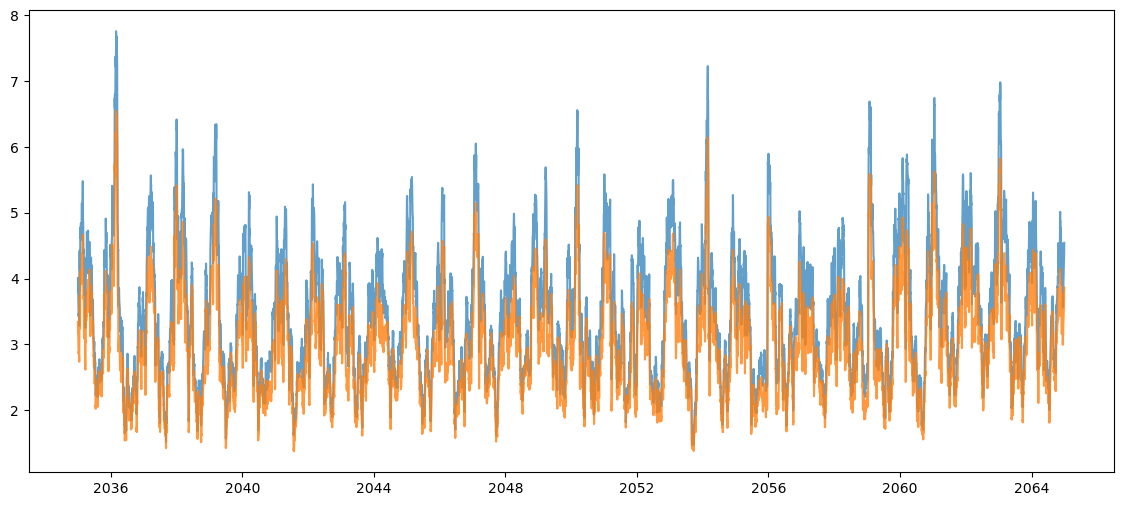

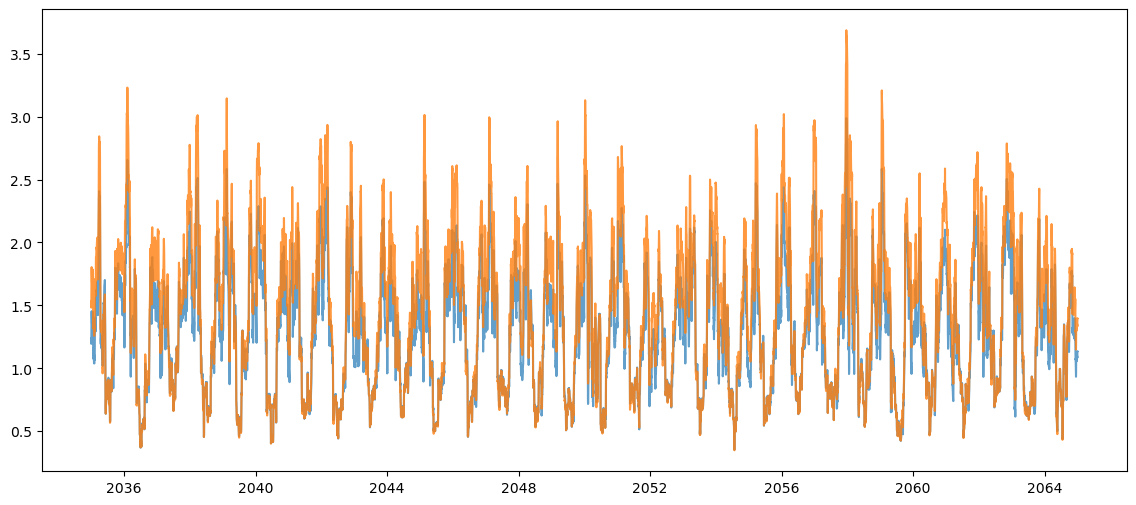

In [52]:
# Main Processing Loop
# ============================================================================

# 1. Generate targets from configuration (one model, one scenario, multiple coordinates)
targets = generate_targets(MODEL, SCENARIOS, COORDINATES)

# 2. Load template
print(f"\n{'='*70}")
print("Loading template .met file...")
print(f"{'='*70}")
try:
    template_header = parse_template_met(TEMPLATE_MET_FILE)
    print(f"  [OK] Template loaded successfully")
except Exception as e:
    print(f"  [ERROR] Failed to load template: {e}")
    raise

# 3. Process each coordinate for the configured model/scenario
print(f"\n{'='*70}")
print(f"Processing {len(targets)} target(s)")
print(f"{'='*70}")

for target_idx, target in enumerate(targets, 1):
    model, scenario, lat, lon = target['model'], target['scenario'], target['lat'], target['lon']
    
    print(f"\n{'='*70}")
    print(f"Target {target_idx}/{len(targets)}: {model} {scenario} ({lat}, {lon})")
    print(f"{'='*70}")
    
    try:
        # Find files (with error handling - skip if files missing)
        print(f"\n[STEP 1] Finding required files...")
        print(f"  [DEBUG] Searching in: {INPUT_MET_DIR}")
        print(f"  [DEBUG] Looking for: {model} {scenario} at ({lat}, {lon})")
        files = find_files_for_target(model, scenario, lat, lon, INPUT_MET_DIR)
        
        # Debug: Show what was found
        print(f"  [DEBUG] Files found:")
        for key, path in files.items():
            if path:
                print(f"    ✓ {key}: {os.path.basename(path)}")
            else:
                print(f"    ✗ {key}: NOT FOUND")
        
        # Check if all required files exist
        if not all_required_files_exist(files, scenario):
            print(f"  [SKIP] Missing required files for {model} {scenario} ({lat}, {lon})")
            print(f"  [INFO] Please ensure all required files exist and run the corresponding calculation notebooks first")
            print(f"  [DEBUG] Searched directory: {INPUT_MET_DIR}")
            # List some example files in the directory to help debug
            try:
                dir_files = os.listdir(INPUT_MET_DIR)
                example_files = [f for f in dir_files if model.lower() in f.lower() or 'silo' in f.lower()][:5]
                if example_files:
                    print(f"  [DEBUG] Example files in directory:")
                    for f in example_files:
                        print(f"    - {f}")
            except Exception as e:
                print(f"  [DEBUG] Could not list directory: {e}")
            continue
        
        print(f"  [OK] All required files found")
        
        # Load data
        print(f"\n[STEP 2] Loading data files...")
        try:
            silo_header, silo_met = load_met_file(files['silo_met'])
            print(f"  [OK] SILO .met: {len(silo_met):,} rows")
            
            cmip6_obs_header, cmip6_obs_met = load_met_file(files['cmip6_obs_met'])
            print(f"  [OK] CMIP6 obs .met: {len(cmip6_obs_met):,} rows")
            
            cmip6_future_header, cmip6_future_met = load_met_file(files['cmip6_future_met'])
            if len(cmip6_future_met) > 0:
                future_date_min = cmip6_future_met['date'].min()
                future_date_max = cmip6_future_met['date'].max()
                print(f"  [OK] CMIP6 future .met: {len(cmip6_future_met):,} rows")
                print(f"      Date range: {future_date_min.date()} to {future_date_max.date()}")
            else:
                print(f"  [OK] CMIP6 future .met: {len(cmip6_future_met):,} rows")
            
            vp_proxy_obs = load_proxy_csv(files['vp_obs'], variable='vp')
            print(f"  [OK] VP obs proxy: {len(vp_proxy_obs):,} rows")
            
            vp_proxy_future = load_proxy_csv(files['vp_future'], variable='vp')
            print(f"  [OK] VP future proxy: {len(vp_proxy_future):,} rows")
            
            evap_proxy_obs = load_proxy_csv(files['evap_obs'], variable='evap')
            print(f"  [OK] Evap obs proxy: {len(evap_proxy_obs):,} rows")
            
            evap_proxy_future = load_proxy_csv(files['evap_future'], variable='evap')
            print(f"  [OK] Evap future proxy: {len(evap_proxy_future):,} rows")
            
            # Check date range alignment between .met file and proxy CSV
            if scenario.lower() != 'obs' and len(vp_proxy_future) > 0 and len(cmip6_future_met) > 0:
                proxy_date_min = vp_proxy_future['date'].min()
                proxy_date_max = vp_proxy_future['date'].max()
                met_date_min = cmip6_future_met['date'].min()
                met_date_max = cmip6_future_met['date'].max()
                
                print(f"\n  [INFO] Date range comparison:")
                print(f"      Proxy CSV: {proxy_date_min.date()} to {proxy_date_max.date()}")
                print(f"      .met file:  {met_date_min.date()} to {met_date_max.date()}")
                
                # Filter .met file to match proxy CSV date range if they don't match
                if met_date_min < proxy_date_min or met_date_max > proxy_date_max:
                    print(f"  [INFO] Filtering .met file to match proxy CSV date range...")
                    cmip6_future_met = cmip6_future_met[
                        (cmip6_future_met['date'] >= proxy_date_min) & 
                        (cmip6_future_met['date'] <= proxy_date_max)
                    ].copy()
                    print(f"  [OK] Filtered .met file: {len(cmip6_future_met):,} rows")
                    print(f"      Filtered date range: {cmip6_future_met['date'].min().date()} to {cmip6_future_met['date'].max().date()}")
                elif met_date_min == proxy_date_min and met_date_max == proxy_date_max:
                    print(f"  [OK] Date ranges match perfectly")
                else:
                    print(f"  [WARNING] Date ranges partially overlap - may cause issues")
        except Exception as e:
            print(f"  [ERROR] Failed to load data files: {e}")
            continue
        
        # Extract VP/Evap from .met files
        print(f"\n[STEP 3] Extracting VP and Evap from .met files...")
        silo_vp = silo_met[['date', 'vp']].copy()
        silo_vp = silo_vp.rename(columns={'vp': 'value'})
        silo_evap = silo_met[['date', 'evap']].copy()
        silo_evap = silo_evap.rename(columns={'evap': 'value'})
        
        # Filter SILO to calibration period (always 1986-2014 for parametrization)
        # Note: SILO only has historical data, so this is always 1986-2014
        calibration_start_dt = pd.to_datetime(CALIBRATION_START)
        calibration_end_dt = pd.to_datetime(CALIBRATION_END)
        silo_vp_calibration = silo_vp[(silo_vp['date'] >= calibration_start_dt) & (silo_vp['date'] <= calibration_end_dt)].copy()
        silo_evap_calibration = silo_evap[(silo_evap['date'] >= calibration_start_dt) & (silo_evap['date'] <= calibration_end_dt)].copy()
        
        # Get scenario-specific baseline period for reporting
        baseline_start, baseline_end = get_baseline_period(scenario)
        baseline_start_dt = pd.to_datetime(baseline_start)
        baseline_end_dt = pd.to_datetime(baseline_end)
        print(f"  [INFO] Using baseline period for {scenario}: {baseline_start} to {baseline_end}")
        print(f"  [INFO] Using calibration period (for parametrization): {CALIBRATION_START} to {CALIBRATION_END}")
        
        print(f"  [OK] SILO VP (calibration period): {len(silo_vp_calibration):,} rows")
        print(f"  [OK] SILO Evap (calibration period): {len(silo_evap_calibration):,} rows")
        
        # Calibrate VP (use calibration period for parametrization)
        print(f"\n[STEP 4] Calibrating VP...")
        try:
            vp_calibration = calibrate_vp(
                silo_vp_calibration,  # Use filtered SILO data for calibration parametrization
                vp_proxy_obs, 
                vp_proxy_future, 
                CALIBRATION_START,  # Always use historical period for parametrization
                CALIBRATION_END
            )
            print(f"  [OK] VP calibration completed")
        except Exception as e:
            print(f"  [ERROR] VP calibration failed: {e}")
            continue
        
        # Calibrate Evap (use calibration period for parametrization)
        print(f"\n[STEP 5] Calibrating Evap...")
        try:
            evap_calibration = calibrate_evap(
                silo_evap_calibration,  # Use filtered SILO data for calibration parametrization
                evap_proxy_obs, 
                evap_proxy_future, 
                CALIBRATION_START,  # Always use historical period for parametrization
                CALIBRATION_END
            )
            print(f"  [OK] Evap calibration completed")
        except Exception as e:
            print(f"  [ERROR] Evap calibration failed: {e}")
            continue
        
        # Write calibrated .met file
        print(f"\n[STEP 6] Writing calibrated .met file...")
        try:
            lat_str = f"{lat:.2f}".replace('-', 'neg')
            lon_str = f"{lon:.2f}"
            output_filename = f"{model}_{scenario}_{lat_str}_{lon_str}_calibrated.met"
            output_path = os.path.join(OUTPUT_DIR, output_filename)
            
            # Select correct met file and calibration results based on scenario
            if scenario.lower() == "obs":
                original_met = cmip6_obs_met
                calibrated_vp_data = vp_calibration['obs']
                calibrated_evap_data = evap_calibration['obs']
            else:
                original_met = cmip6_future_met
                calibrated_vp_data = vp_calibration['future']
                calibrated_evap_data = evap_calibration['future']
            
            write_calibrated_met(
                original_met,
                calibrated_vp_data,
                calibrated_evap_data,
                template_header,
                output_path,
                model,
                scenario,
                lat,
                lon
            )
            print(f"  [OK] Calibrated .met file created: {output_filename}")
            
            # Also write raw (non-calibrated) .met file
            raw_output_filename = f"{model}_{scenario}_{lat_str}_{lon_str}.met"
            raw_output_path = os.path.join(OUTPUT_DIR, raw_output_filename)
            
            # Select correct raw proxy data based on scenario
            if scenario.lower() == "obs":
                raw_vp_data = vp_proxy_obs.copy()
                raw_evap_data = evap_proxy_obs.copy()
            else:
                raw_vp_data = vp_proxy_future.copy()
                raw_evap_data = evap_proxy_future.copy()
            
            # Ensure raw data has 'date' and 'value' columns
            if 'date' not in raw_vp_data.columns or 'value' not in raw_vp_data.columns:
                # If columns are different, try to rename
                if len(raw_vp_data.columns) == 2:
                    raw_vp_data.columns = ['date', 'value']
            if 'date' not in raw_evap_data.columns or 'value' not in raw_evap_data.columns:
                if len(raw_evap_data.columns) == 2:
                    raw_evap_data.columns = ['date', 'value']
            
            write_calibrated_met(
                original_met,
                raw_vp_data,
                raw_evap_data,
                template_header,
                raw_output_path,
                model,
                scenario,
                lat,
                lon
            )
            print(f"  [OK] Raw .met file created: {raw_output_filename}")
        except Exception as e:
            print(f"  [ERROR] Failed to write calibrated .met file: {e}")
            print(f"  [SKIP] Skipping diagnostics - .met file creation failed")
            import traceback
            traceback.print_exc()
            continue
        
        # Generate diagnostics and report
        print(f"\n[STEP 7] Generating diagnostics and report...")
        try:
            diagnostics_vp = generate_diagnostics(
                silo_vp_calibration,  # Use calibration period SILO data
                vp_proxy_obs,
                vp_calibration['obs'],
                vp_calibration['future'],
                vp_calibration['silo_stats'],
                vp_calibration['cmip6_obs_stats'],
                variable='vp',
                baseline_start=baseline_start,  # Use scenario-specific baseline
                baseline_end=baseline_end
            )
            
            diagnostics_evap = generate_diagnostics(
                silo_evap_calibration,  # Use calibration period SILO data
                evap_proxy_obs,
                evap_calibration['obs'],
                evap_calibration['future'],
                evap_calibration['silo_stats'],
                evap_calibration['cmip6_obs_stats'],
                variable='evap',
                baseline_start=baseline_start,  # Use scenario-specific baseline
                baseline_end=baseline_end
            )
            
            write_calibration_report(
                model, lat, lon,
                diagnostics_vp, diagnostics_evap,
                OUTPUT_DIR,
                baseline_start, baseline_end  # Use scenario-specific baseline
            )
            
            print(f"  [OK] Diagnostics and report generated")
        except Exception as e:
            print(f"  [WARNING] Failed to generate diagnostics: {e}")
            import traceback
            traceback.print_exc()

        # Run comprehensive diagnostic validation
        print(f"\n[STEP 8] Running diagnostic validation...")
        try:
            validation_summary = run_diagnostic_validation(
                silo_vp_calibration,  # Use calibration period SILO data
                silo_evap_calibration,  # Use calibration period SILO data
                vp_proxy_obs,
                evap_proxy_obs,
                vp_calibration,
                evap_calibration,
                vp_proxy_future,
                evap_proxy_future,
                cmip6_future_met,
                baseline_start,  # Use scenario-specific baseline
                baseline_end,  # Use scenario-specific baseline
                model,
                scenario,
                lat,
                lon,
                OUTPUT_DIR
            )
            print(f"  [OK] Diagnostic validation completed")
        except Exception as e:
            print(f"  [ERROR] Diagnostic validation failed: {e}")
            import traceback
            traceback.print_exc()
            # Don't continue - validation errors are critical
            continue
        
        print(f"\n{'='*70}")
        print(f"[SUCCESS] Completed processing: {model} {scenario} ({lat}, {lon})")
        print(f"{'='*70}")
        
    except Exception as e:
        print(f"\n  [ERROR] Unexpected error processing target: {e}")
        import traceback
        traceback.print_exc()
        continue

print(f"\n{'='*70}")
print("[COMPLETE] All targets processed!")
print(f"{'='*70}")
print(f"Output directory: {OUTPUT_DIR}")
